In [1]:
from JIT_accelerated_code import *
from tqdm import tqdm

### Accelerated IG Estimation

Processing:   0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\Bill\AppData\Local\Temp\ipykernel_22760\2938121757.py:118: RuntimeWarning: invalid value encountered in sqrt
  sigmaw = np.sqrt(sigmaw2)
Processing: 100%|██████████| 1000/1000 [00:08<00:00, 121.11it/s]
C:\Users\Bill\AppData\Local\Temp\ipykernel_22760\2938121757.py:161: RuntimeWarning: invalid value encountered in sqrt
  std_devs = np.sqrt([np.diag(cov) for cov in inferred_covs_array])


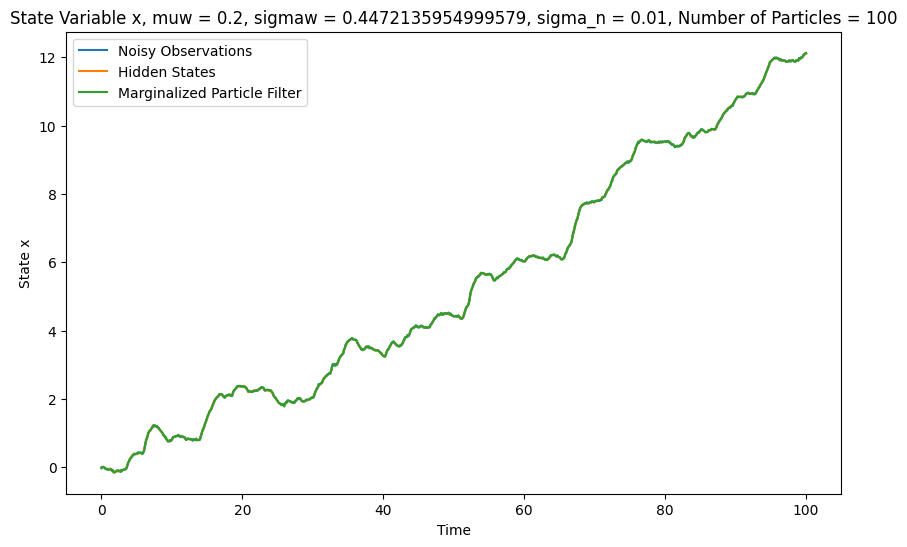

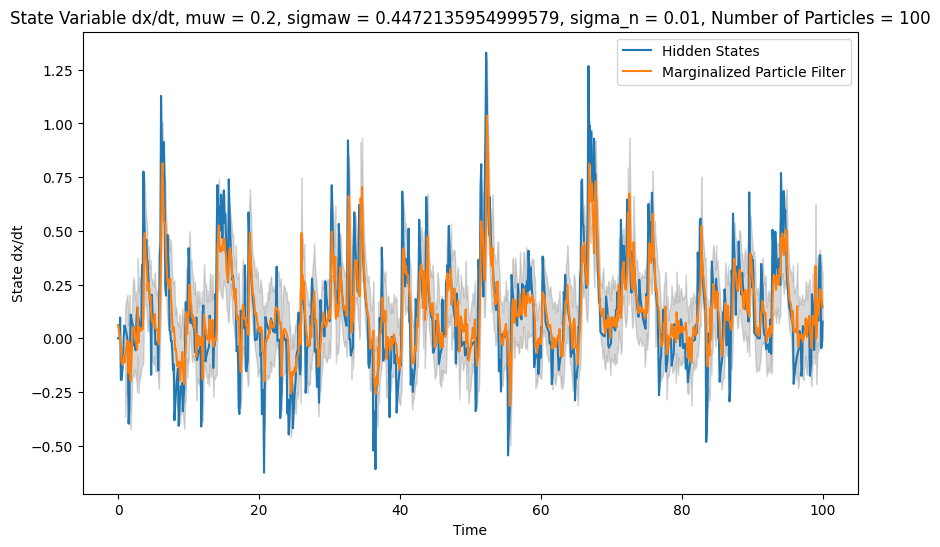

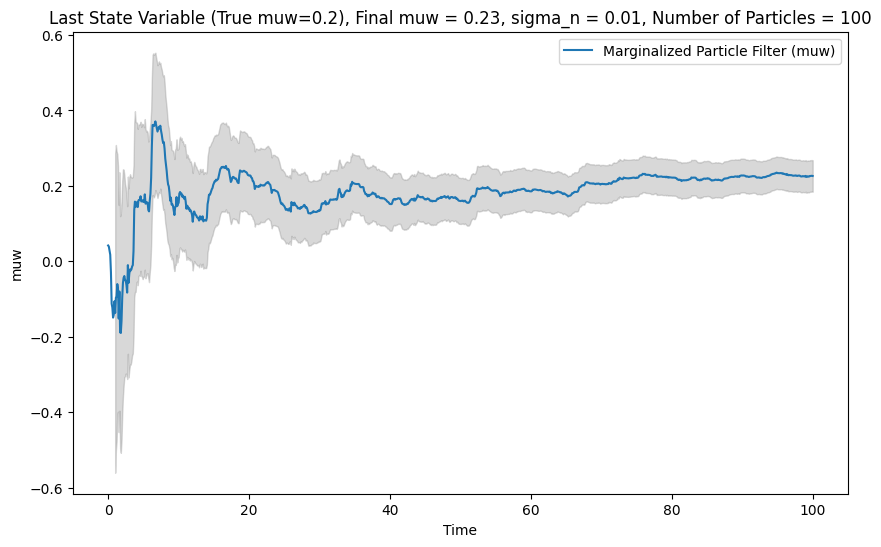

C:\Users\Bill\AppData\Local\Temp\ipykernel_22760\2938121757.py:241: RuntimeWarning: invalid value encountered in sqrt
  sigmaw2_upper_bound = [val + np.sqrt(unc) for val, unc in zip(sigmaw2_values, sigmaw2_uncertainties)]
C:\Users\Bill\AppData\Local\Temp\ipykernel_22760\2938121757.py:242: RuntimeWarning: invalid value encountered in sqrt
  sigmaw2_lower_bound = [val - np.sqrt(unc) for val, unc in zip(sigmaw2_values, sigmaw2_uncertainties)]


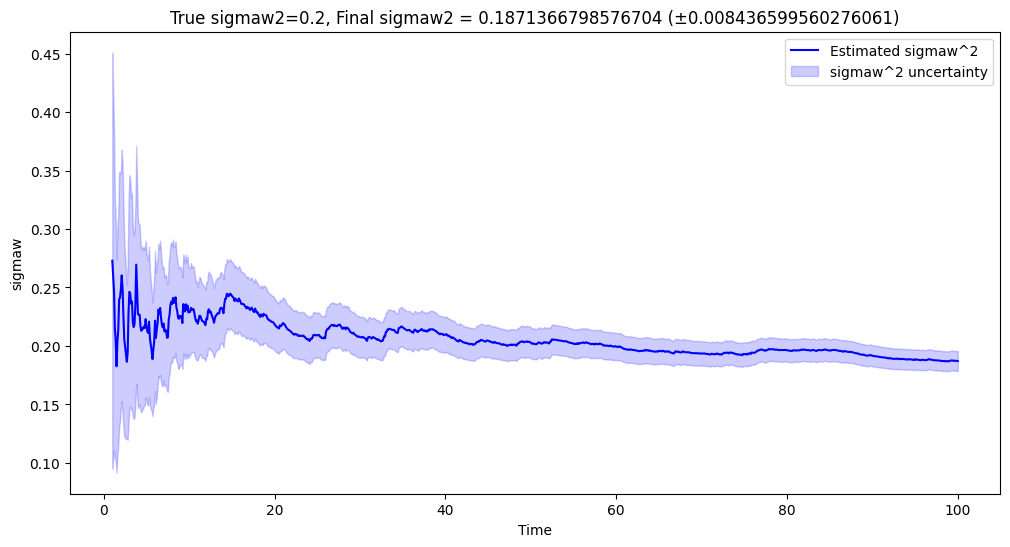

In [3]:
from JIT_accelerated_code import *
from tqdm import tqdm
#Again, we first generate the noisy observations.
#We again have the noisy data first:
#Again, we first generate the noisy observations.
#We again have the noisy data first:

kw = 1 #The prior parameter for muw

kv = 0.001 #The observation noise scaling factor. Note that this scaling factor applies to the variance
true_sigmaw2 = 0.2
true_muw = 0.2
true_sigmaw = np.sqrt(true_sigmaw2)
sigma_n = true_sigmaw * np.sqrt(kv)

num_particles = 1000

#Prior inverted gamma parameters for sigmaw
alphaws = 0.0000000001 * np.ones(num_particles)
betaws = 0.0000000001 * np.ones(num_particles)
accumulated_Es = np.zeros(num_particles)
accumulated_Fs = np.zeros(num_particles)

#Simulation Parameters
theta = -2 #The main control parameter for the Lagevin system
beta = 5
C = 10
T = 100


N = T*10  # Resolution

#Define the Langevin dynamics
A = np.zeros((2, 2))
A[0, 1] = 1
A[1, 1] = theta
h = np.array([[0], [1]])

#Simulation
evaluation_points = np.linspace(0, T, N) #Note that this would be the time axis we work on.
normal_gamma_generator = normal_gamma_process(beta, C, T, true_muw, true_sigmaw)
langevin = SDE(A,h,T,normal_gamma_generator)
#Noisy observation generation
SDE_samples,system_jumps,NVM_jumps,subordinator_jumps,jump_times = langevin.generate_samples(evaluation_points,all_data=True)
d1,d2 = np.shape(SDE_samples)
#Noisy_samples = SDE_samples + np.random.randn(d1,d2)*sigma_n #The noisy observations simulated. Already in the column vector form


#Create the partial observation, observing only the integral state x here.
Noisy_samples = SDE_samples[:,0] + np.random.randn(np.shape(SDE_samples)[0])*sigma_n #The noisy observations simulated. Already in the column vector form






trajectory = []


#Kalman filter initialisation
X0 = Noisy_samples[0]
nx0 = 2
X0 = np.zeros((nx0+1,1))
nx0_new = 3

#The margianlised Kalman covariance
C_prior = np.zeros((nx0_new,nx0_new))
C_prior[-1,-1] = kw

g = np.array([[1],[0],[0]])
g = g.T
R = np.array([kv]) #The noise covariance matrix. Same observation noise throughout




#Particle filter Initialisation    
initial_particles = []
for i in range(num_particles):
    initial_particles.append([np.zeros((nx0,1)),np.eye(nx0)])
previous_Xs = []
previous_X_uncertaintys = []
for i in range(num_particles):
    previous_X_uncertaintys.append(C_prior)
    previous_Xs.append(X0)
# Define initial weights (uniform)
initial_weights = np.ones(num_particles) / num_particles


# Time step size and sigma for the likelihood function
dt = evaluation_points[1] - evaluation_points[0]
matrix_exp = expm(A*dt)
sigma = sigma_n #The observatin noise



#Containers for the imnference results
inferred_Xs = []
inferred_covs = []
first_time = True

# Running the particle filter
particles = initial_particles
histories = [particles]
weights = initial_weights




sigmaw2_values = []
sigmaw2_uncertainties = []
alphas = []
betas = []

for i in tqdm(range(len(evaluation_points)),desc = "Processing"): #i is the time index we want for N
    #sigmaw here needs to be updated in every step
    sigmaw2,sigmaw2_uncertainty = inverted_gamma_to_mean_variance(np.array(alphaws), np.array(betaws),np.array(weights)) #Note that this is sigmaw^2 but not sigmaw
    sigmaw = np.sqrt(sigmaw2)

    sigmaw2_values.append(sigmaw2)
    sigmaw2_uncertainties.append(sigmaw2_uncertainty)


    incremental_normal_gamma_generator = normal_gamma_process(beta, C, dt, 0, sigmaw) #We are just using the built in gamma generator inside， putting in some random muw or sigmaw has no effect
    incremental_SDE = SDE(A,h,dt,incremental_normal_gamma_generator)
    t = evaluation_points[i]
    observation = Noisy_samples[i] #Note that the observation here is still a row vector, reshaping necessary
    previous_Xs, previous_X_uncertaintys,particles,weights,alphaws, betaws, accumulated_Es, accumulated_Fs  = ultimate_NVM_pf(observation, previous_Xs, previous_X_uncertaintys, particles, transition_function_ultimate_NVM_pf, matrix_exp, dt,incremental_SDE,g,R,alphaws,betaws,accumulated_Es,accumulated_Fs,i) # N is the time nidex
    inferred_cov = weighted_sum(previous_X_uncertaintys,weights) * sigmaw2 #Note that the original parameters are marginalised by sigmaw^2
    inferred_X = weighted_sum(previous_Xs,weights)
    
    histories.append(particles)
    
    inferred_Xs.append(inferred_X)
    inferred_covs.append(inferred_cov)










trajectory = np.array(trajectory)
    

#These are the returns
##########################################################################################################################################
inferred_Xs_array = np.array(inferred_Xs)

# Convert inferred_covs to a NumPy array for easier manipulation
inferred_covs_array = np.array(inferred_covs)




# Calculate standard deviation (sqrt of variance) for each state variable at each time step
# Ensuring the shape of std_devs matches with inferred_Xs_array
std_devs = np.sqrt([np.diag(cov) for cov in inferred_covs_array])

# Convert std_devs to a numpy array for consistent array operations
std_devs_array = np.array(std_devs)

# Plotting with uncertainty range for the first state variable
num_states = inferred_Xs_array.shape[1]


last_state_muw = inferred_Xs_array[:, -1, 0]
last_state_std_dev = std_devs_array[:, -1]


# 这部分代码用于在绘图标题中动态显示参数值
# 注意：这段代码假设前面的所有变量和过程已经按照原始代码正确运行

# 获取最后的muw和sigmaw估计值及其不确定性
final_muw_estimate = last_state_muw[-1]
final_sigmaw2_estimate = sigmaw2_values[-1]
final_sigmaw2_uncertainty = sigmaw2_uncertainties[-1]





skip = 10 #skip the first few variance estimates due to instability


# 更新绘图代码以包含动态参数值
# 以下只展示修改后的绘图部分


# 第一个状态变量的绘图
plt.figure(figsize=(10, 6))
plt.plot(evaluation_points, Noisy_samples, label="Noisy Observations")
plt.plot(evaluation_points, SDE_samples[:, 0], label="Hidden States")
plt.plot(evaluation_points, inferred_Xs_array[:, 0, 0], label="Marginalized Particle Filter")
# 跳过错误带的前几个点
plt.fill_between(evaluation_points[skip:], 
                 inferred_Xs_array[skip:, 0, 0] - std_devs_array[skip:, 0], 
                 inferred_Xs_array[skip:, 0, 0] + std_devs_array[skip:, 0], 
                 color='gray', alpha=0.3)
plt.title(f"State Variable x, muw = {true_muw}, sigmaw = {true_sigmaw}, sigma_n = {sigma_n:.2f}, Number of Particles = {num_particles}")
plt.xlabel('Time')
plt.ylabel('State x')
plt.legend()
plt.show()

# 第二个状态变量的绘图，同样跳过错误带的前几个点
plt.figure(figsize=(10, 6))
plt.plot(evaluation_points, SDE_samples[:, 1], label="Hidden States")
plt.plot(evaluation_points, inferred_Xs_array[:, 1, 0], label="Marginalized Particle Filter")
plt.fill_between(evaluation_points[skip:], 
                 inferred_Xs_array[skip:, 1, 0] - std_devs_array[skip:, 1], 
                 inferred_Xs_array[skip:, 1, 0] + std_devs_array[skip:, 1], 
                 color='gray', alpha=0.3)
plt.title(f"State Variable dx/dt, muw = {true_muw}, sigmaw = {true_sigmaw}, sigma_n = {sigma_n:.2f}, Number of Particles = {num_particles}")
plt.xlabel('Time')
plt.ylabel('State dx/dt')
plt.legend()
plt.show()

# muw的绘图
plt.figure(figsize=(10, 6))
plt.plot(evaluation_points, last_state_muw, label="Marginalized Particle Filter (muw)")
plt.fill_between(evaluation_points[skip:], 
                 last_state_muw[skip:] - last_state_std_dev[skip:], 
                 last_state_muw[skip:] + last_state_std_dev[skip:], 
                 color='gray', alpha=0.3)
plt.title(f"Last State Variable (True muw={true_muw}), Final muw = {final_muw_estimate:.2f}, sigma_n = {sigma_n:.2f}, Number of Particles = {num_particles}")
plt.xlabel('Time')
plt.ylabel('muw')
plt.legend()
plt.show()

# 绘制sigmaw值和其不确定性范围
plt.figure(figsize=(12, 6))
plt.plot(evaluation_points[skip:], sigmaw2_values[skip:], label='Estimated sigmaw^2', color='blue')

# 计算sigmaw的不确定性上下界
sigmaw2_upper_bound = [val + np.sqrt(unc) for val, unc in zip(sigmaw2_values, sigmaw2_uncertainties)]
sigmaw2_lower_bound = [val - np.sqrt(unc) for val, unc in zip(sigmaw2_values, sigmaw2_uncertainties)]

# 绘制sigmaw不确定性范围
plt.fill_between(evaluation_points[skip:], sigmaw2_lower_bound[skip:], sigmaw2_upper_bound[skip:], color='blue', alpha=0.2, label='sigmaw^2 uncertainty')

plt.xlabel('Time')
plt.ylabel('sigmaw')
plt.title(f'True sigmaw2={true_sigmaw2}, Final sigmaw2 = {final_sigmaw2_estimate} (±{np.sqrt(sigmaw2_uncertainties[-1])})')
plt.legend()
plt.show()




Processing: 100%|██████████| 100/100 [4:12:31<00:00, 151.52s/it] 


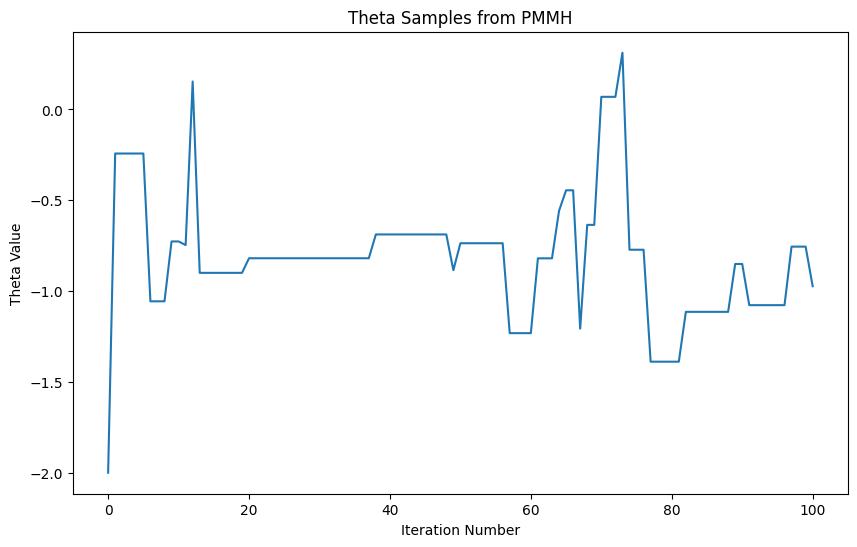

Mean of theta: -0.8151437219890503
Median of theta: -0.8191041913628274
95% confidence interval of theta: [-1.38864509  0.06959896]


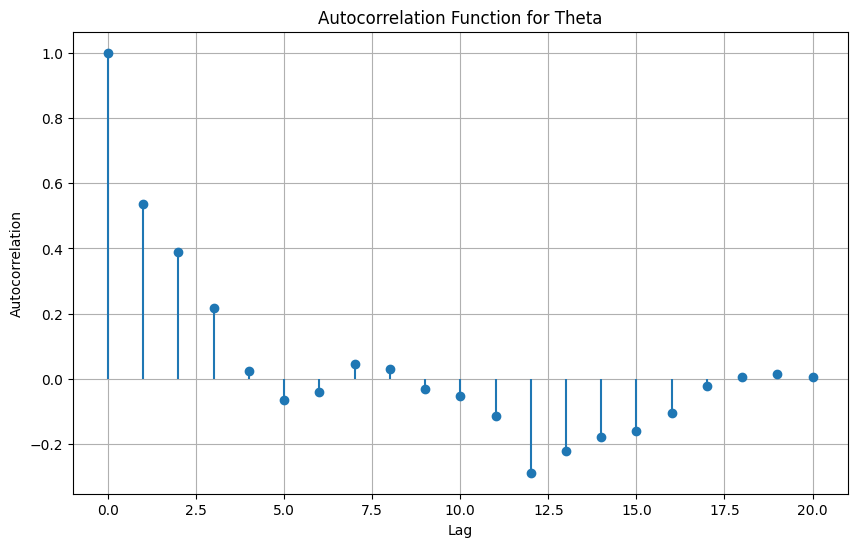

Estimated Autocorrelation Time: 0.985116634223399


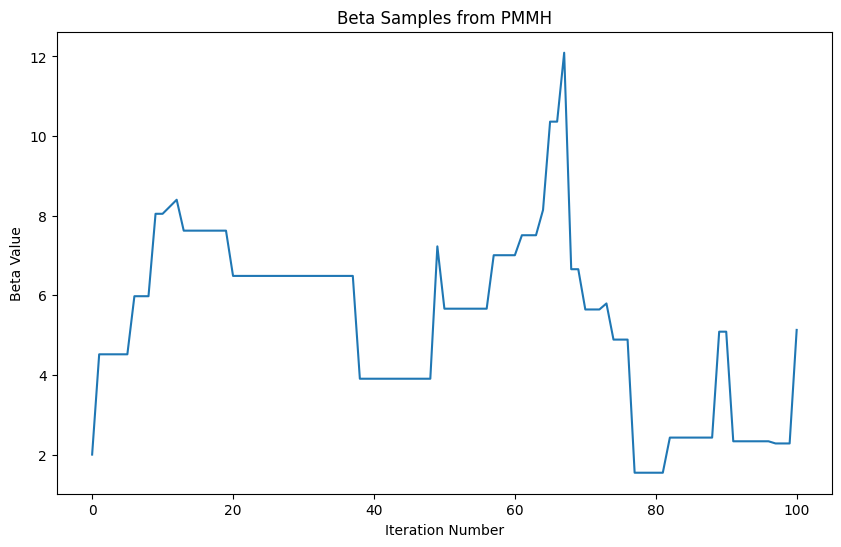

Mean of beta: 5.33033033109678
Median of beta: 5.664809871342673
95% confidence interval of beta: [1.5446168  9.38226906]


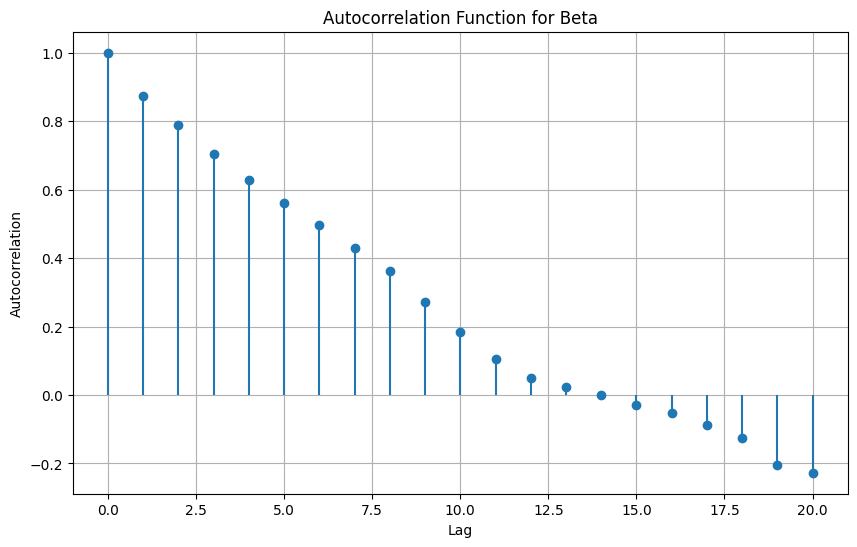

Estimated Autocorrelation Time: 10.504492045008318


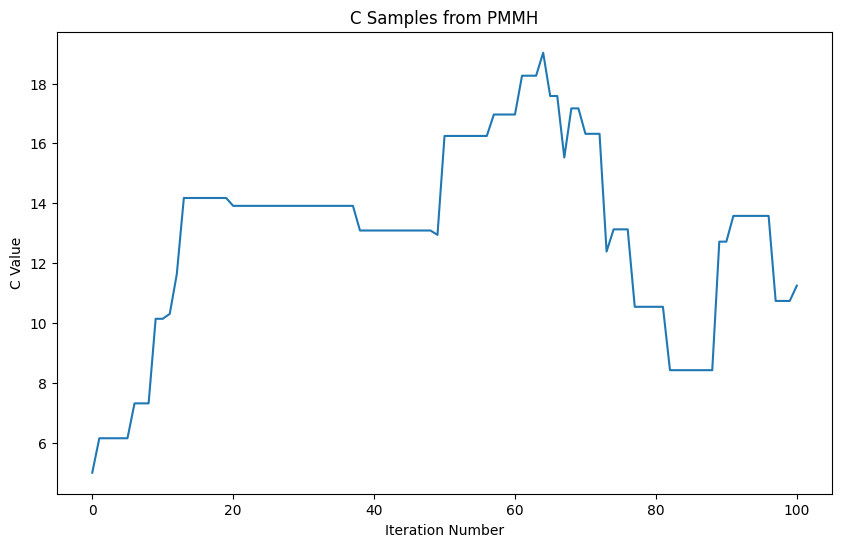

Mean of C: 12.96802244323805
Median of C: 13.578305330744065
95% confidence interval of C: [ 6.15135747 18.26053059]


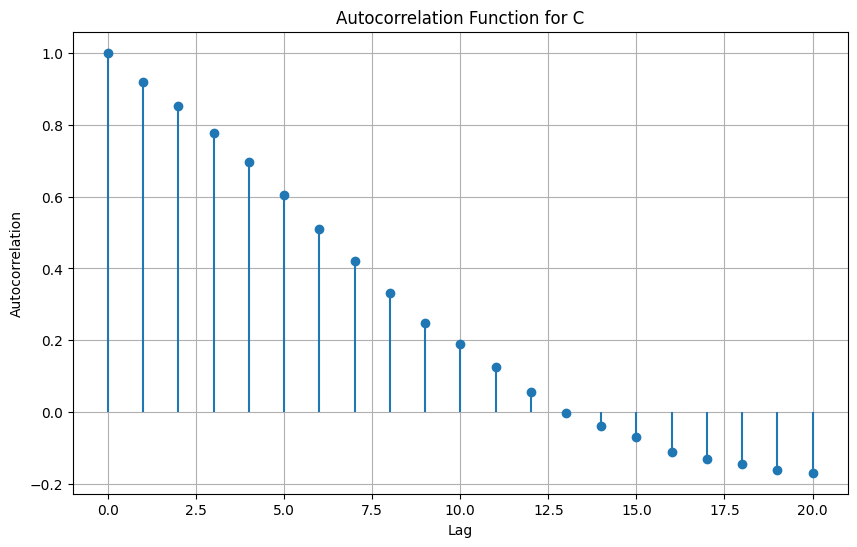

Estimated Autocorrelation Time: 10.808852085874976


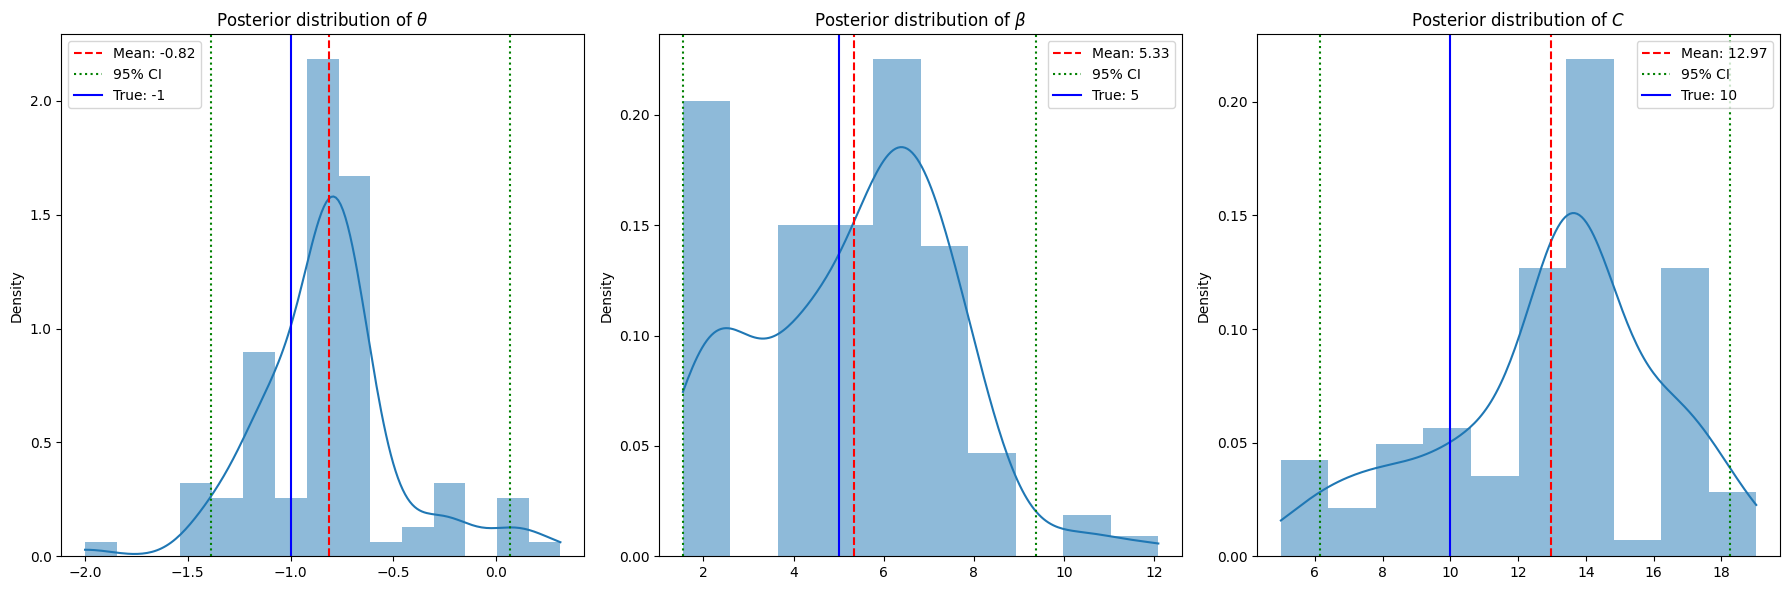

In [3]:
from JIT_accelerated_code import *
from tqdm import tqdm
import seaborn as sns
#Again, we first generate the noisy observations.
#We again have the noisy data first:
#Again, we first generate the noisy observations.
#We again have the noisy data first:


#beta_pcn = 1 #The step parameter for the pre-conditioned crank nicolson algorithm
n_iter = 100 #Number of iterations
theta0 = -2 #Initial guess of theta
beta0 = 2 #Initial Guess of beta
C0 = 5  #Initial Guess of C  
num_particles = 1000

#The 3 step sizes for the 3 parameters
l_theta = 1 
l_beta = 2
l_C = 2





true_theta = -1 #The true theta value for the Langevin system


kw = 1 #The prior parameter for muw

kv = 0.001 #The observation noise scaling factor. Note that this scaling factor applies to the variance
true_sigmaw = 2
true_muw = 0.2
sigma_n = true_sigmaw * np.sqrt(kv)


#Simulation Parameters

true_beta = 5
true_C = 10
T = 50


N = 10 * T  # Resolution, 10 points per unit time now

#Define the Langevin dynamics
A = np.zeros((2, 2))
A[0, 1] = 1
A[1, 1] = true_theta
h = np.array([[0], [1]])

#Simulation
evaluation_points = np.linspace(0, T, N) #Note that this would be the time axis we work on.
normal_gamma_generator = normal_gamma_process(true_beta, true_C, T, true_muw, true_sigmaw)
langevin = SDE(A,h,T,normal_gamma_generator)
#Noisy observation generation
SDE_samples,system_jumps,NVM_jumps,subordinator_jumps,jump_times = langevin.generate_samples(evaluation_points,all_data=True)
d1,d2 = np.shape(SDE_samples)
#Noisy_samples = SDE_samples + np.random.randn(d1,d2)*sigma_n #The noisy observations simulated. Already in the column vector form


#Create the partial observation, observing only the integral state x here.
Noisy_samples = SDE_samples[:,0] + np.random.randn(np.shape(SDE_samples)[0])*sigma_n #The noisy observations simulated. Already in the column vector form


#The collection of the parameter samples
theta_samples = [theta0]
C_samples = [C0]
beta_samples = [beta0]
first_time = True

for iter in tqdm(range(n_iter), desc="Processing"):



    if first_time:
        #print("Progress:",progress/searching_resolution, "%")
        #progress +=1
        #Prior inverted gamma parameters for sigmaw
        alphaws = 2.1 * np.ones(num_particles)
        betaws = 1 * np.ones(num_particles)
        accumulated_Es = np.zeros(num_particles)
        accumulated_Fs = np.zeros(num_particles)

        trajectory = []
        A = np.zeros((2, 2))
        A[0, 1] = 1
        A[1, 1] = theta_samples[-1]

        #Kalman filter initialisation
        X0 = Noisy_samples[0]
        nx0 = 2
        X0 = np.zeros((nx0+1,1))
        nx0_new = 3

        #The margianlised Kalman covariance
        C_prior = np.zeros((nx0_new,nx0_new))
        C_prior[-1,-1] = kw

        g = np.array([[1],[0],[0]])
        g = g.T
        R = np.array([kv]) #The noise covariance matrix. Same observation noise throughout




        #Particle filter Initialisation    
        initial_particles = []
        for i in range(num_particles):
            initial_particles.append([np.zeros((nx0,1)),np.eye(nx0)])
        previous_Xs = []
        previous_X_uncertaintys = []
        for i in range(num_particles):
            previous_X_uncertaintys.append(C_prior)
            previous_Xs.append(X0)
        # Define initial weights (uniform)
        initial_weights = np.ones(num_particles) / num_particles

        

        # Time step size and sigma for the likelihood function
        dt = evaluation_points[1] - evaluation_points[0]
        matrix_exp = expm(A*dt)
        sigma = sigma_n #The observatin noise



        #Containers for the imnference results
        inferred_Xs = []
        inferred_covs = []
        first_time = True

        # Running the particle filter
        particles = initial_particles
        histories = [particles]
        weights = initial_weights




        sigmaw_values = []
        

        

        for i in range(len(evaluation_points)): #i is the time index we want for N
            #sigmaw here needs to be updated in every step
            sigmaw2,sigmaw2_uncertainty = inverted_gamma_to_mean_variance(alphaws, betaws,weights) #Note that this is sigmaw^2 but not sigmaw
            sigmaw = np.sqrt(sigmaw2)

            sigmaw_values.append(sigmaw)
            


            incremental_normal_gamma_generator = normal_gamma_process(beta_samples[-1], C_samples[-1], dt, 0, sigmaw) #We are just using the built in gamma generator inside， putting in some random muw or sigmaw has no effect
            incremental_SDE = SDE(A,h,dt,incremental_normal_gamma_generator)
            #print(i)
            t = evaluation_points[i]
            observation = Noisy_samples[i] #Note that the observation here is still a row vector, reshaping necessary
            previous_Xs, previous_X_uncertaintys,particles,weights,alphaws, betaws, accumulated_Es, accumulated_Fs,log_marginals  = ultimate_NVM_pf(observation, previous_Xs, previous_X_uncertaintys, particles, transition_function_ultimate_NVM_pf, matrix_exp, dt,incremental_SDE,g,R,alphaws,betaws,accumulated_Es,accumulated_Fs,i,return_log_marginals=True) # N is the time nidex
            inferred_cov = weighted_sum(previous_X_uncertaintys,weights) * sigmaw2 #Note that the original parameters are marginalised by sigmaw^2
            inferred_X = weighted_sum(previous_Xs,weights)
            
            histories.append(particles)
            
            inferred_Xs.append(inferred_X)
            inferred_covs.append(inferred_cov)
            log_marginals = np.array(log_marginals)

        original_state_log_probability = logsumexp(log_marginals) - np.log(num_particles)
        first_time = False





    #####################################################################################################################################################################################################################################################
    #From here, we propose a the parameter samples, indepndent parameter assumed

    theta_proposed = theta_samples[-1] + np.random.randn() * l_theta
    beta_proposed = beta_samples[-1] + np.random.randn() * l_beta
    C_proposed = C_samples[-1] + np.random.randn() * l_C
    #Note that the Gamma process parameters have to be positive
    if beta_proposed <=0:
        beta_proposed = 0.000001
    if C_proposed <= 0:
        C_proposeed = 0.000001
    #print("Progress:",progress/searching_resolution, "%")
    #progress +=1
    #Prior inverted gamma parameters for sigmaw
    alphaws = 2.1 * np.ones(num_particles)
    betaws = 1 * np.ones(num_particles)
    accumulated_Es = np.zeros(num_particles)
    accumulated_Fs = np.zeros(num_particles)

    trajectory = []
    A = np.zeros((2, 2))
    A[0, 1] = 1
    A[1, 1] = theta_proposed

    #Kalman filter initialisation
    X0 = Noisy_samples[0]
    nx0 = 2
    X0 = np.zeros((nx0+1,1))
    nx0_new = 3

    #The margianlised Kalman covariance
    C_prior = np.zeros((nx0_new,nx0_new))
    C_prior[-1,-1] = kw

    g = np.array([[1],[0],[0]])
    g = g.T
    R = np.array([kv]) #The noise covariance matrix. Same observation noise throughout




    #Particle filter Initialisation    
    initial_particles = []
    for i in range(num_particles):
        initial_particles.append([np.zeros((nx0,1)),np.eye(nx0)])
    previous_Xs = []
    previous_X_uncertaintys = []
    for i in range(num_particles):
        previous_X_uncertaintys.append(C_prior)
        previous_Xs.append(X0)
    # Define initial weights (uniform)
    initial_weights = np.ones(num_particles) / num_particles

    

    # Time step size and sigma for the likelihood function
    dt = evaluation_points[1] - evaluation_points[0]
    matrix_exp = expm(A*dt)
    sigma = sigma_n #The observatin noise



    #Containers for the imnference results
    inferred_Xs = []
    inferred_covs = []
    first_time = True

    # Running the particle filter
    particles = initial_particles
    histories = [particles]
    weights = initial_weights




    sigmaw_values = []
    

    for i in range(len(evaluation_points)): #i is the time index we want for N
        #sigmaw here needs to be updated in every step
        sigmaw2,sigmaw2_uncertainty = inverted_gamma_to_mean_variance(alphaws, betaws,weights)
        sigmaw = np.sqrt(sigmaw2)

        sigmaw_values.append(sigmaw)
       


        incremental_normal_gamma_generator = normal_gamma_process(beta_proposed, C_proposed, dt, 0, sigmaw) #We are just using the built in gamma generator inside， putting in some random muw or sigmaw has no effect
        incremental_SDE = SDE(A,h,dt,incremental_normal_gamma_generator)
        #print(i)
        t = evaluation_points[i]
        observation = Noisy_samples[i] #Note that the observation here is still a row vector, reshaping necessary
        previous_Xs, previous_X_uncertaintys,particles,weights,alphaws, betaws, accumulated_Es, accumulated_Fs,log_marginals  = ultimate_NVM_pf(observation, previous_Xs, previous_X_uncertaintys, particles, transition_function_ultimate_NVM_pf, matrix_exp, dt,incremental_SDE,g,R,alphaws,betaws,accumulated_Es,accumulated_Fs,i,return_log_marginals=True) # N is the time nidex
        inferred_cov = weighted_sum(previous_X_uncertaintys,weights) * sigmaw2 #Note that the original parameters are marginalised by sigmaw^2
        inferred_X = weighted_sum(previous_Xs,weights)
        
        histories.append(particles)
        
        inferred_Xs.append(inferred_X)
        inferred_covs.append(inferred_cov)
        log_marginals = np.array(log_marginals)

    proposed_state_log_probability = logsumexp(log_marginals) - np.log(num_particles)


    ##################################################################################################################################################################################################################################
    # Acceptance Attempt
    log_acceptance_ratio = proposed_state_log_probability - original_state_log_probability
    if np.log(np.random.rand())< log_acceptance_ratio: #Accepted case
        theta_samples.append(theta_proposed)
        beta_samples.append(beta_proposed)
        C_samples.append(C_proposed)
        original_state_log_probability = proposed_state_log_probability
    else: #Rejected case
        theta_samples.append(theta_samples[-1])
        beta_samples.append(beta_samples[-1])
        C_samples.append(C_samples[-1])


theta_samples = np.array(theta_samples)  # 假设已经去除了燃烧期的样本
beta_samples = np.array(beta_samples)
C_samples = np.array(C_samples)

# 后验分布摘要 for theta
mean_theta = np.mean(theta_samples)
median_theta = np.median(theta_samples)
conf_interval = np.percentile(theta_samples, [2.5, 97.5])  # 95%置信区间

plt.figure(figsize=(10, 6))
plt.plot(theta_samples)
plt.xlabel("Iteration Number")
plt.ylabel("Theta Value")
plt.title("Theta Samples from PMMH")
plt.show()


# 打印摘要统计量
print(f"Mean of theta: {mean_theta}")
print(f"Median of theta: {median_theta}")
print(f"95% confidence interval of theta: {conf_interval}")


plot_autocorrelation(theta_samples,parameter_name = "Theta")


# 后验分布摘要 for beta
mean_beta = np.mean(beta_samples)
median_beta = np.median(beta_samples)
conf_interval = np.percentile(beta_samples, [2.5, 97.5])  # 95%置信区间

plt.figure(figsize=(10, 6))
plt.plot(beta_samples)
plt.xlabel("Iteration Number")
plt.ylabel("Beta Value")
plt.title("Beta Samples from PMMH")
plt.show()


# 打印摘要统计量
print(f"Mean of beta: {mean_beta}")
print(f"Median of beta: {median_beta}")
print(f"95% confidence interval of beta: {conf_interval}")

plot_autocorrelation(beta_samples, parameter_name="Beta")


# 后验分布摘要
mean_C = np.mean(C_samples)
median_C = np.median(C_samples)
conf_interval = np.percentile(C_samples, [2.5, 97.5])  # 95%置信区间

plt.figure(figsize=(10, 6))
plt.plot(C_samples)
plt.xlabel("Iteration Number")
plt.ylabel("C Value")
plt.title("C Samples from PMMH")
plt.show()


# 打印摘要统计量
print(f"Mean of C: {mean_C}")
print(f"Median of C: {median_C}")
print(f"95% confidence interval of C: {conf_interval}")

plot_autocorrelation(C_samples, parameter_name="C")





# 后验分布摘要和可视化
plt.figure(figsize=(18, 6))

# Theta
plt.subplot(1, 3, 1)
sns.histplot(theta_samples, kde=True, stat="density", linewidth=0)
plt.axvline(np.mean(theta_samples), color='r', linestyle='--', label=f'Mean: {np.mean(theta_samples):.2f}')
plt.axvline(np.percentile(theta_samples, 2.5), color='g', linestyle=':', label='95% CI')
plt.axvline(np.percentile(theta_samples, 97.5), color='g', linestyle=':')
plt.axvline(true_theta, color='blue', linestyle='-', label=f'True: {true_theta}')
plt.title('Posterior distribution of $\\theta$')
plt.legend()

# Beta
plt.subplot(1, 3, 2)
sns.histplot(beta_samples, kde=True, stat="density", linewidth=0)
plt.axvline(np.mean(beta_samples), color='r', linestyle='--', label=f'Mean: {np.mean(beta_samples):.2f}')
plt.axvline(np.percentile(beta_samples, 2.5), color='g', linestyle=':', label='95% CI')
plt.axvline(np.percentile(beta_samples, 97.5), color='g', linestyle=':')
plt.axvline(true_beta, color='blue', linestyle='-', label=f'True: {true_beta}')
plt.title('Posterior distribution of $\\beta$')
plt.legend()

# C
plt.subplot(1, 3, 3)
sns.histplot(C_samples, kde=True, stat="density", linewidth=0)
plt.axvline(np.mean(C_samples), color='r', linestyle='--', label=f'Mean: {np.mean(C_samples):.2f}')
plt.axvline(np.percentile(C_samples, 2.5), color='g', linestyle=':', label='95% CI')
plt.axvline(np.percentile(C_samples, 97.5), color='g', linestyle=':')
plt.axvline(true_C, color='blue', linestyle='-', label=f'True: {true_C}')
plt.title('Posterior distribution of $C$')
plt.legend()

plt.tight_layout()
plt.show()



Processing: 100%|██████████| 500/500 [3:32:06<00:00, 25.45s/it]  


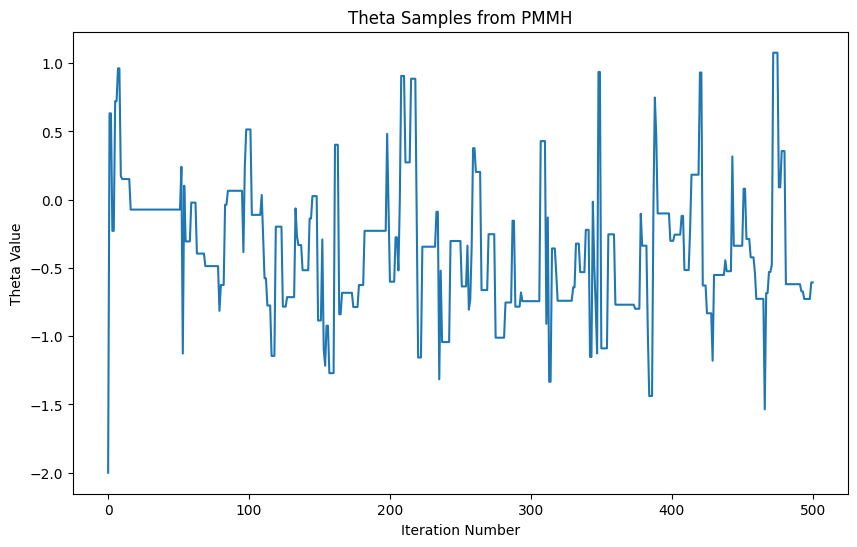

Mean of theta: -0.36774259503892437
Median of theta: -0.34429938109186453
95% confidence interval of theta: [-1.19762142  0.89658918]


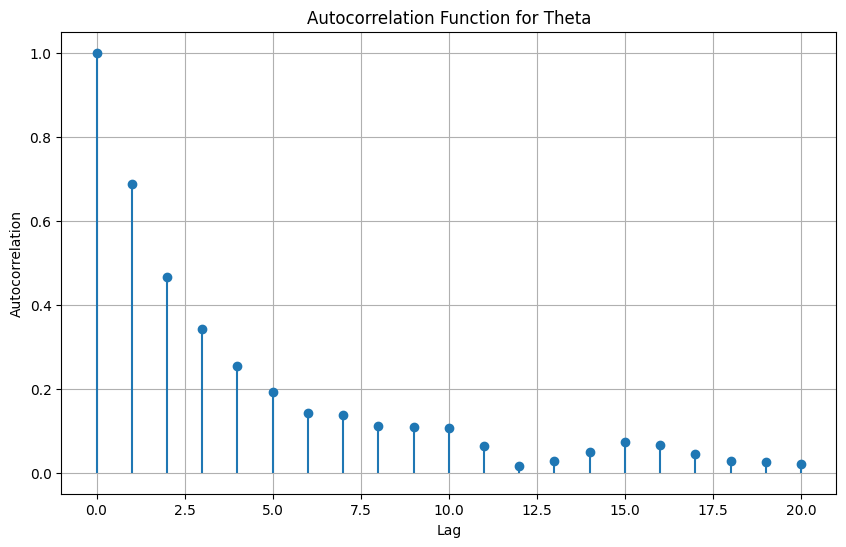

Estimated Autocorrelation Time: 6.924631589648594


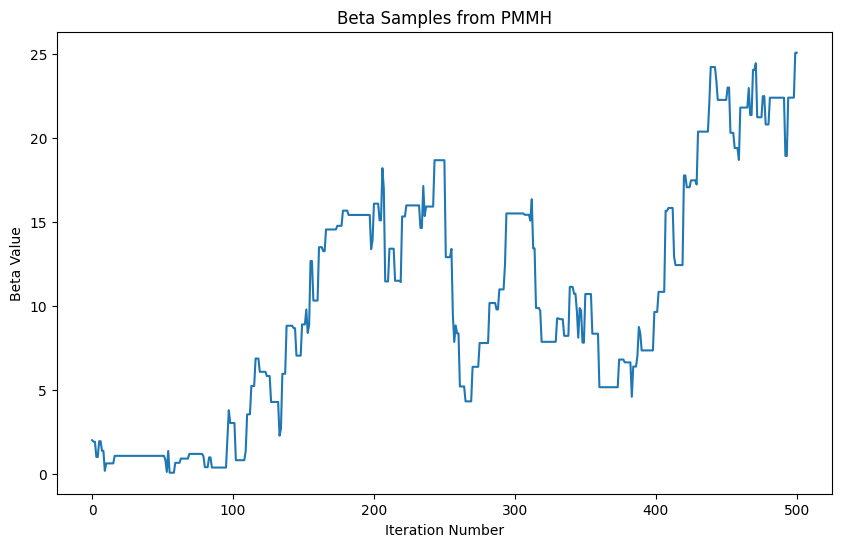

Mean of beta: 10.306807926656507
Median of beta: 9.700166584572214
95% confidence interval of beta: [ 0.3714962  22.73259177]


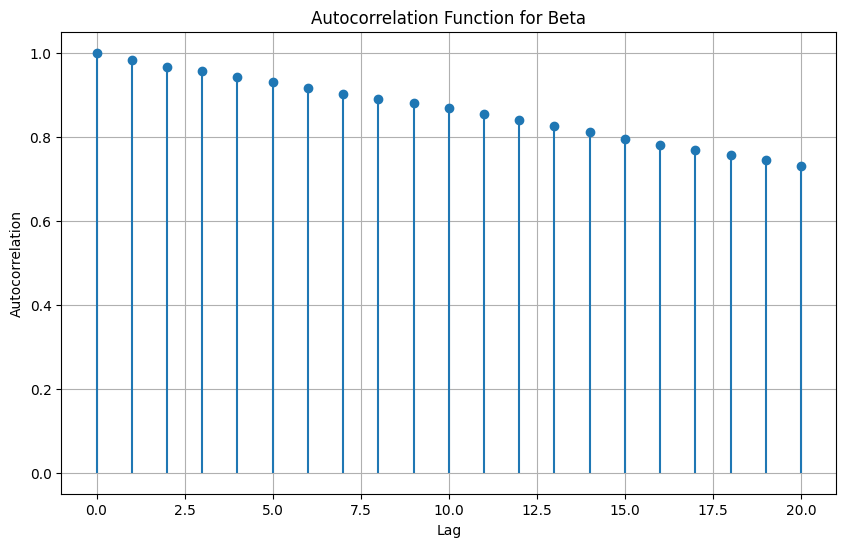

Estimated Autocorrelation Time: 35.28330120916323


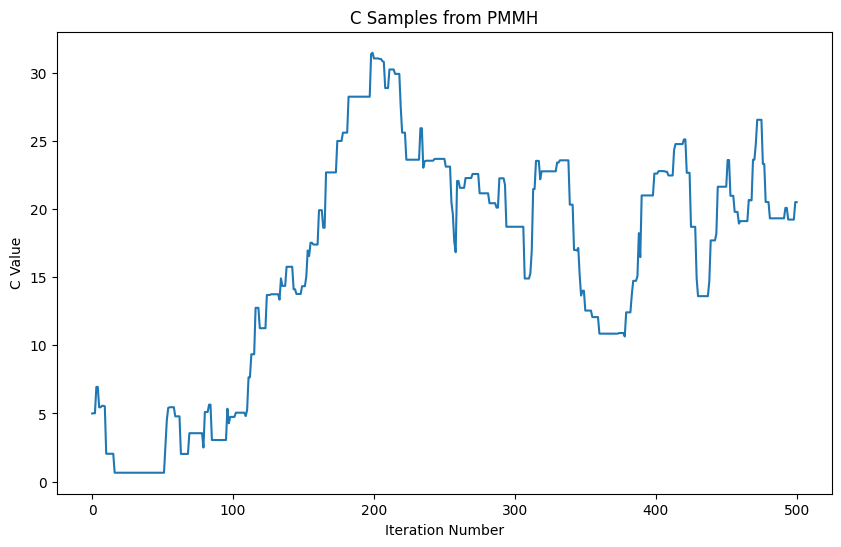

Mean of C: 16.33057376364409
Median of C: 18.698384463971102
95% confidence interval of C: [ 0.65335993 30.23659076]


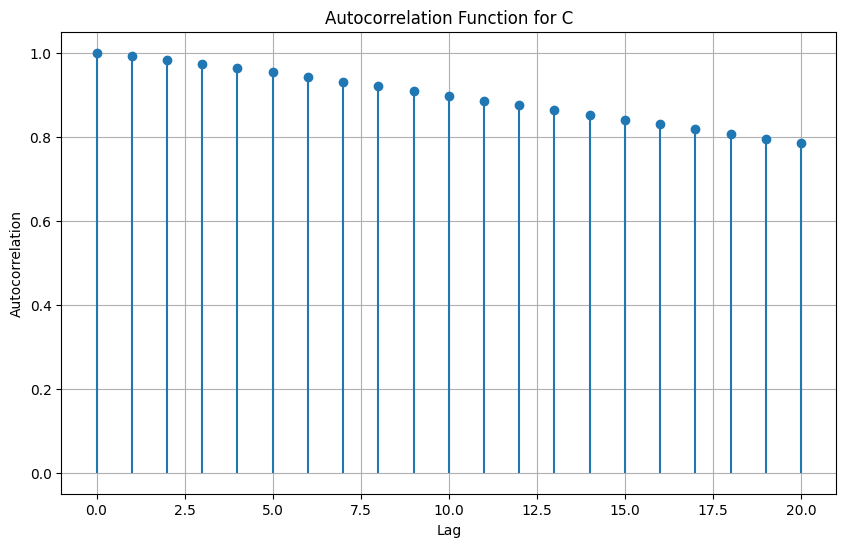

Estimated Autocorrelation Time: 36.62450568363969


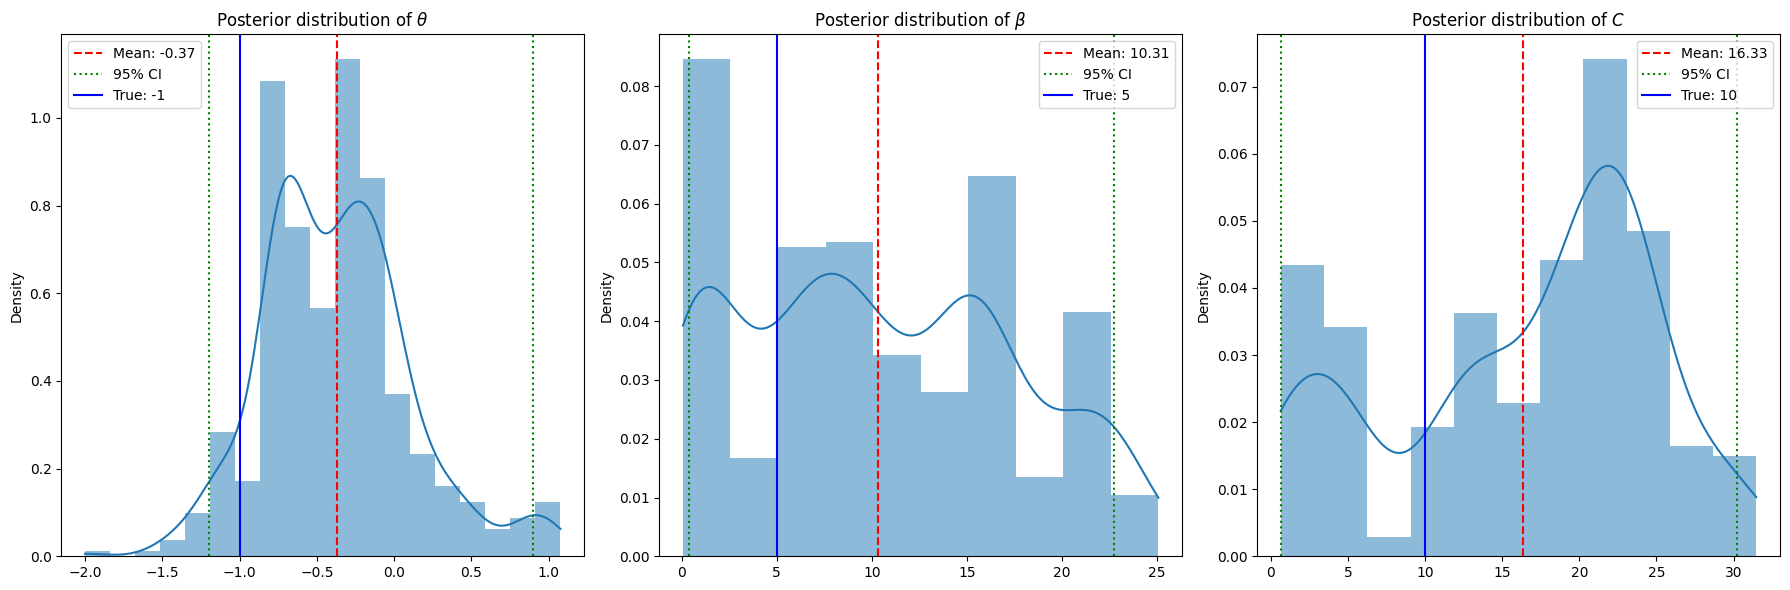

In [4]:
from JIT_accelerated_code import *
from tqdm import tqdm
import seaborn as sns
#Again, we first generate the noisy observations.
#We again have the noisy data first:
#Again, we first generate the noisy observations.
#We again have the noisy data first:


#beta_pcn = 1 #The step parameter for the pre-conditioned crank nicolson algorithm
n_iter = 500 #Number of iterations
theta0 = -2 #Initial guess of theta
beta0 = 2 #Initial Guess of beta
C0 = 5  #Initial Guess of C  
num_particles = 1000

#The 3 step sizes for the 3 parameters
l_theta = 1 
l_beta = 2
l_C = 2





true_theta = -1 #The true theta value for the Langevin system


kw = 1 #The prior parameter for muw

kv = 0.001 #The observation noise scaling factor. Note that this scaling factor applies to the variance
true_sigmaw = 2
true_muw = 0.2
sigma_n = true_sigmaw * np.sqrt(kv)


#Simulation Parameters

true_beta = 5
true_C = 10
T = 10


N = 10 * T  # Resolution, 10 points per unit time now

#Define the Langevin dynamics
A = np.zeros((2, 2))
A[0, 1] = 1
A[1, 1] = true_theta
h = np.array([[0], [1]])

#Simulation
evaluation_points = np.linspace(0, T, N) #Note that this would be the time axis we work on.
normal_gamma_generator = normal_gamma_process(true_beta, true_C, T, true_muw, true_sigmaw)
langevin = SDE(A,h,T,normal_gamma_generator)
#Noisy observation generation
SDE_samples,system_jumps,NVM_jumps,subordinator_jumps,jump_times = langevin.generate_samples(evaluation_points,all_data=True)
d1,d2 = np.shape(SDE_samples)
#Noisy_samples = SDE_samples + np.random.randn(d1,d2)*sigma_n #The noisy observations simulated. Already in the column vector form


#Create the partial observation, observing only the integral state x here.
Noisy_samples = SDE_samples[:,0] + np.random.randn(np.shape(SDE_samples)[0])*sigma_n #The noisy observations simulated. Already in the column vector form


#The collection of the parameter samples
theta_samples = [theta0]
C_samples = [C0]
beta_samples = [beta0]
first_time = True

for iter in tqdm(range(n_iter), desc="Processing"):



    if first_time:
        #print("Progress:",progress/searching_resolution, "%")
        #progress +=1
        #Prior inverted gamma parameters for sigmaw
        alphaws = 2.1 * np.ones(num_particles)
        betaws = 1 * np.ones(num_particles)
        accumulated_Es = np.zeros(num_particles)
        accumulated_Fs = np.zeros(num_particles)

        trajectory = []
        A = np.zeros((2, 2))
        A[0, 1] = 1
        A[1, 1] = theta_samples[-1]

        #Kalman filter initialisation
        X0 = Noisy_samples[0]
        nx0 = 2
        X0 = np.zeros((nx0+1,1))
        nx0_new = 3

        #The margianlised Kalman covariance
        C_prior = np.zeros((nx0_new,nx0_new))
        C_prior[-1,-1] = kw

        g = np.array([[1],[0],[0]])
        g = g.T
        R = np.array([kv]) #The noise covariance matrix. Same observation noise throughout




        #Particle filter Initialisation    
        initial_particles = []
        for i in range(num_particles):
            initial_particles.append([np.zeros((nx0,1)),np.eye(nx0)])
        previous_Xs = []
        previous_X_uncertaintys = []
        for i in range(num_particles):
            previous_X_uncertaintys.append(C_prior)
            previous_Xs.append(X0)
        # Define initial weights (uniform)
        initial_weights = np.ones(num_particles) / num_particles

        

        # Time step size and sigma for the likelihood function
        dt = evaluation_points[1] - evaluation_points[0]
        matrix_exp = expm(A*dt)
        sigma = sigma_n #The observatin noise



        #Containers for the imnference results
        inferred_Xs = []
        inferred_covs = []
        first_time = True

        # Running the particle filter
        particles = initial_particles
        histories = [particles]
        weights = initial_weights




        sigmaw_values = []
        

        

        for i in range(len(evaluation_points)): #i is the time index we want for N
            #sigmaw here needs to be updated in every step
            sigmaw2,sigmaw2_uncertainty = inverted_gamma_to_mean_variance(alphaws, betaws,weights) #Note that this is sigmaw^2 but not sigmaw
            sigmaw = np.sqrt(sigmaw2)

            sigmaw_values.append(sigmaw)
            


            incremental_normal_gamma_generator = normal_gamma_process(beta_samples[-1], C_samples[-1], dt, 0, sigmaw) #We are just using the built in gamma generator inside， putting in some random muw or sigmaw has no effect
            incremental_SDE = SDE(A,h,dt,incremental_normal_gamma_generator)
            #print(i)
            t = evaluation_points[i]
            observation = Noisy_samples[i] #Note that the observation here is still a row vector, reshaping necessary
            previous_Xs, previous_X_uncertaintys,particles,weights,alphaws, betaws, accumulated_Es, accumulated_Fs,log_marginals  = ultimate_NVM_pf(observation, previous_Xs, previous_X_uncertaintys, particles, transition_function_ultimate_NVM_pf, matrix_exp, dt,incremental_SDE,g,R,alphaws,betaws,accumulated_Es,accumulated_Fs,i,return_log_marginals=True) # N is the time nidex
            inferred_cov = weighted_sum(previous_X_uncertaintys,weights) * sigmaw2 #Note that the original parameters are marginalised by sigmaw^2
            inferred_X = weighted_sum(previous_Xs,weights)
            
            histories.append(particles)
            
            inferred_Xs.append(inferred_X)
            inferred_covs.append(inferred_cov)
            log_marginals = np.array(log_marginals)

        original_state_log_probability = logsumexp(log_marginals) - np.log(num_particles)
        first_time = False





    #####################################################################################################################################################################################################################################################
    #From here, we propose a the parameter samples, indepndent parameter assumed

    theta_proposed = theta_samples[-1] + np.random.randn() * l_theta
    beta_proposed = beta_samples[-1] + np.random.randn() * l_beta
    C_proposed = C_samples[-1] + np.random.randn() * l_C
    #Note that the Gamma process parameters have to be positive
    if beta_proposed <=0:
        beta_proposed = 0.000001
    if C_proposed <= 0:
        C_proposeed = 0.000001
    #print("Progress:",progress/searching_resolution, "%")
    #progress +=1
    #Prior inverted gamma parameters for sigmaw
    alphaws = 2.1 * np.ones(num_particles)
    betaws = 1 * np.ones(num_particles)
    accumulated_Es = np.zeros(num_particles)
    accumulated_Fs = np.zeros(num_particles)

    trajectory = []
    A = np.zeros((2, 2))
    A[0, 1] = 1
    A[1, 1] = theta_proposed

    #Kalman filter initialisation
    X0 = Noisy_samples[0]
    nx0 = 2
    X0 = np.zeros((nx0+1,1))
    nx0_new = 3

    #The margianlised Kalman covariance
    C_prior = np.zeros((nx0_new,nx0_new))
    C_prior[-1,-1] = kw

    g = np.array([[1],[0],[0]])
    g = g.T
    R = np.array([kv]) #The noise covariance matrix. Same observation noise throughout




    #Particle filter Initialisation    
    initial_particles = []
    for i in range(num_particles):
        initial_particles.append([np.zeros((nx0,1)),np.eye(nx0)])
    previous_Xs = []
    previous_X_uncertaintys = []
    for i in range(num_particles):
        previous_X_uncertaintys.append(C_prior)
        previous_Xs.append(X0)
    # Define initial weights (uniform)
    initial_weights = np.ones(num_particles) / num_particles

    

    # Time step size and sigma for the likelihood function
    dt = evaluation_points[1] - evaluation_points[0]
    matrix_exp = expm(A*dt)
    sigma = sigma_n #The observatin noise



    #Containers for the imnference results
    inferred_Xs = []
    inferred_covs = []
    first_time = True

    # Running the particle filter
    particles = initial_particles
    histories = [particles]
    weights = initial_weights




    sigmaw_values = []
    

    for i in range(len(evaluation_points)): #i is the time index we want for N
        #sigmaw here needs to be updated in every step
        sigmaw2,sigmaw2_uncertainty = inverted_gamma_to_mean_variance(alphaws, betaws,weights)
        sigmaw = np.sqrt(sigmaw2)

        sigmaw_values.append(sigmaw)
       


        incremental_normal_gamma_generator = normal_gamma_process(beta_proposed, C_proposed, dt, 0, sigmaw) #We are just using the built in gamma generator inside， putting in some random muw or sigmaw has no effect
        incremental_SDE = SDE(A,h,dt,incremental_normal_gamma_generator)
        #print(i)
        t = evaluation_points[i]
        observation = Noisy_samples[i] #Note that the observation here is still a row vector, reshaping necessary
        previous_Xs, previous_X_uncertaintys,particles,weights,alphaws, betaws, accumulated_Es, accumulated_Fs,log_marginals  = ultimate_NVM_pf(observation, previous_Xs, previous_X_uncertaintys, particles, transition_function_ultimate_NVM_pf, matrix_exp, dt,incremental_SDE,g,R,alphaws,betaws,accumulated_Es,accumulated_Fs,i,return_log_marginals=True) # N is the time nidex
        inferred_cov = weighted_sum(previous_X_uncertaintys,weights) * sigmaw2 #Note that the original parameters are marginalised by sigmaw^2
        inferred_X = weighted_sum(previous_Xs,weights)
        
        histories.append(particles)
        
        inferred_Xs.append(inferred_X)
        inferred_covs.append(inferred_cov)
        log_marginals = np.array(log_marginals)

    proposed_state_log_probability = logsumexp(log_marginals) - np.log(num_particles)


    ##################################################################################################################################################################################################################################
    # Acceptance Attempt
    log_acceptance_ratio = proposed_state_log_probability - original_state_log_probability
    if np.log(np.random.rand())< log_acceptance_ratio: #Accepted case
        theta_samples.append(theta_proposed)
        beta_samples.append(beta_proposed)
        C_samples.append(C_proposed)
        original_state_log_probability = proposed_state_log_probability
    else: #Rejected case
        theta_samples.append(theta_samples[-1])
        beta_samples.append(beta_samples[-1])
        C_samples.append(C_samples[-1])


theta_samples = np.array(theta_samples)  # 假设已经去除了燃烧期的样本
beta_samples = np.array(beta_samples)
C_samples = np.array(C_samples)

# 后验分布摘要 for theta
mean_theta = np.mean(theta_samples)
median_theta = np.median(theta_samples)
conf_interval = np.percentile(theta_samples, [2.5, 97.5])  # 95%置信区间

plt.figure(figsize=(10, 6))
plt.plot(theta_samples)
plt.xlabel("Iteration Number")
plt.ylabel("Theta Value")
plt.title("Theta Samples from PMMH")
plt.show()


# 打印摘要统计量
print(f"Mean of theta: {mean_theta}")
print(f"Median of theta: {median_theta}")
print(f"95% confidence interval of theta: {conf_interval}")


plot_autocorrelation(theta_samples,parameter_name = "Theta")


# 后验分布摘要 for beta
mean_beta = np.mean(beta_samples)
median_beta = np.median(beta_samples)
conf_interval = np.percentile(beta_samples, [2.5, 97.5])  # 95%置信区间

plt.figure(figsize=(10, 6))
plt.plot(beta_samples)
plt.xlabel("Iteration Number")
plt.ylabel("Beta Value")
plt.title("Beta Samples from PMMH")
plt.show()


# 打印摘要统计量
print(f"Mean of beta: {mean_beta}")
print(f"Median of beta: {median_beta}")
print(f"95% confidence interval of beta: {conf_interval}")

plot_autocorrelation(beta_samples, parameter_name="Beta")


# 后验分布摘要
mean_C = np.mean(C_samples)
median_C = np.median(C_samples)
conf_interval = np.percentile(C_samples, [2.5, 97.5])  # 95%置信区间

plt.figure(figsize=(10, 6))
plt.plot(C_samples)
plt.xlabel("Iteration Number")
plt.ylabel("C Value")
plt.title("C Samples from PMMH")
plt.show()


# 打印摘要统计量
print(f"Mean of C: {mean_C}")
print(f"Median of C: {median_C}")
print(f"95% confidence interval of C: {conf_interval}")

plot_autocorrelation(C_samples, parameter_name="C")





# 后验分布摘要和可视化
plt.figure(figsize=(18, 6))

# Theta
plt.subplot(1, 3, 1)
sns.histplot(theta_samples, kde=True, stat="density", linewidth=0)
plt.axvline(np.mean(theta_samples), color='r', linestyle='--', label=f'Mean: {np.mean(theta_samples):.2f}')
plt.axvline(np.percentile(theta_samples, 2.5), color='g', linestyle=':', label='95% CI')
plt.axvline(np.percentile(theta_samples, 97.5), color='g', linestyle=':')
plt.axvline(true_theta, color='blue', linestyle='-', label=f'True: {true_theta}')
plt.title('Posterior distribution of $\\theta$')
plt.legend()

# Beta
plt.subplot(1, 3, 2)
sns.histplot(beta_samples, kde=True, stat="density", linewidth=0)
plt.axvline(np.mean(beta_samples), color='r', linestyle='--', label=f'Mean: {np.mean(beta_samples):.2f}')
plt.axvline(np.percentile(beta_samples, 2.5), color='g', linestyle=':', label='95% CI')
plt.axvline(np.percentile(beta_samples, 97.5), color='g', linestyle=':')
plt.axvline(true_beta, color='blue', linestyle='-', label=f'True: {true_beta}')
plt.title('Posterior distribution of $\\beta$')
plt.legend()

# C
plt.subplot(1, 3, 3)
sns.histplot(C_samples, kde=True, stat="density", linewidth=0)
plt.axvline(np.mean(C_samples), color='r', linestyle='--', label=f'Mean: {np.mean(C_samples):.2f}')
plt.axvline(np.percentile(C_samples, 2.5), color='g', linestyle=':', label='95% CI')
plt.axvline(np.percentile(C_samples, 97.5), color='g', linestyle=':')
plt.axvline(true_C, color='blue', linestyle='-', label=f'True: {true_C}')
plt.title('Posterior distribution of $C$')
plt.legend()

plt.tight_layout()
plt.show()



In [4]:
! pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


## $\beta$ Search

Processing: 100%|██████████| 300/300 [8:00:57<00:00, 96.19s/it]   


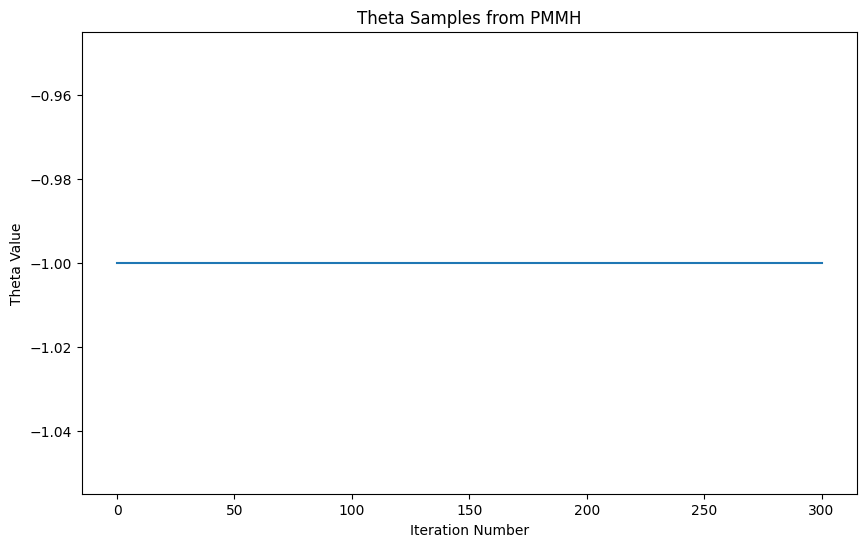

Mean of theta: -1.0
Median of theta: -1.0
95% confidence interval of theta: [-1. -1.]


e:\Cambridge\Year 4\Fourth Year Projcet\IIB_Codes\JIT_accelerated_code.py:66: RuntimeWarning: invalid value encountered in divide
  acf = np.correlate(samples - mean, samples - mean, mode='full')[n-1:] / (var*n)
e:\Intern\BIRL\source_code\yolov5_venv\Lib\site-packages\matplotlib\axes\_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


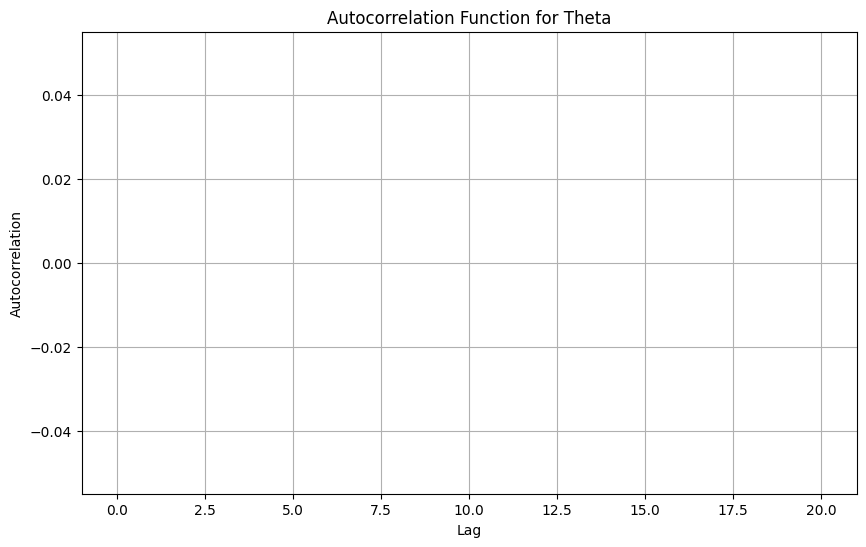

Estimated Autocorrelation Time: nan


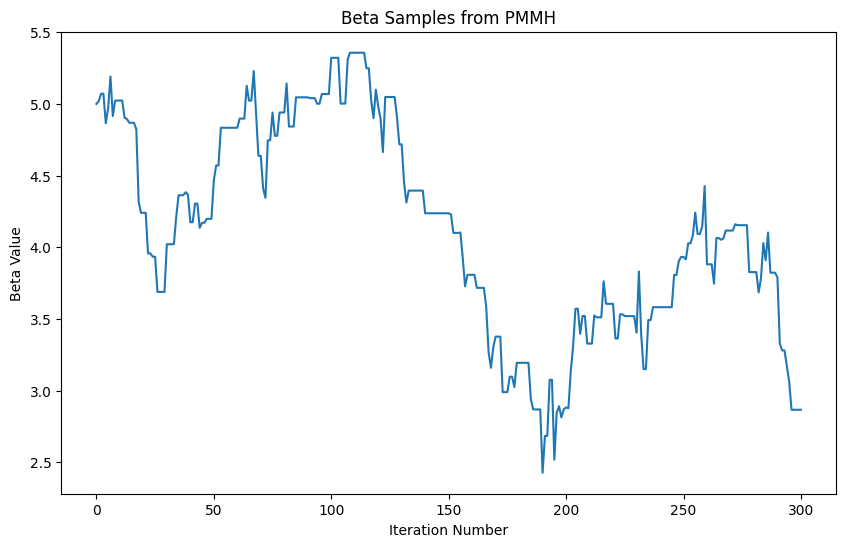

Mean of beta: 4.125151375936222
Median of beta: 4.116747352391079
95% confidence interval of beta: [2.86698733 5.32173273]


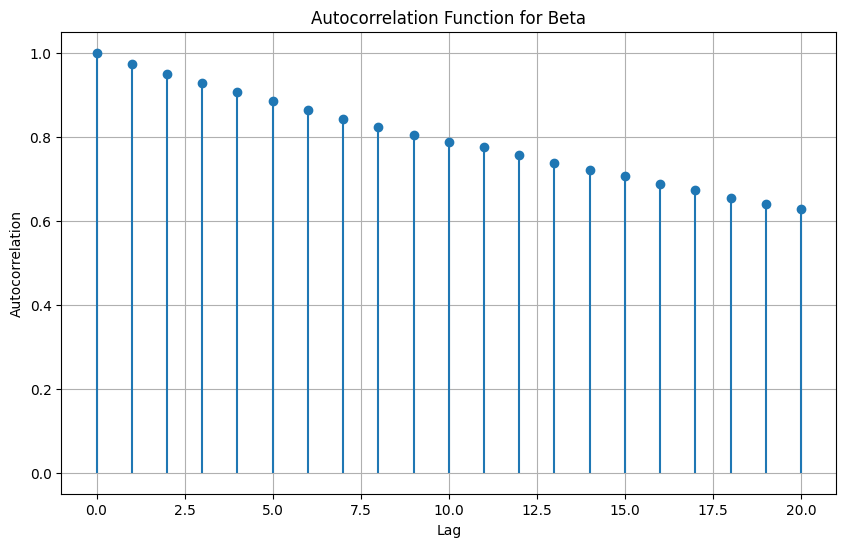

Estimated Autocorrelation Time: 32.48308111915418


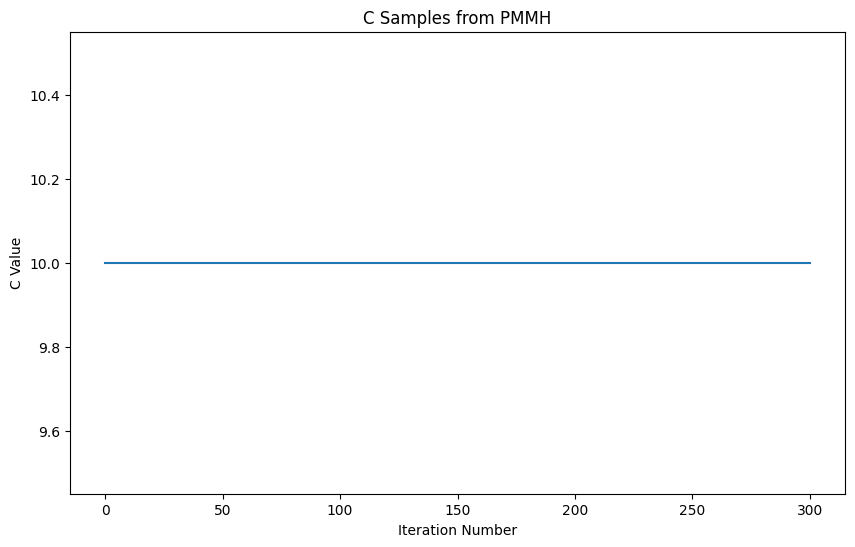

Mean of C: 10.0
Median of C: 10.0
95% confidence interval of C: [10. 10.]


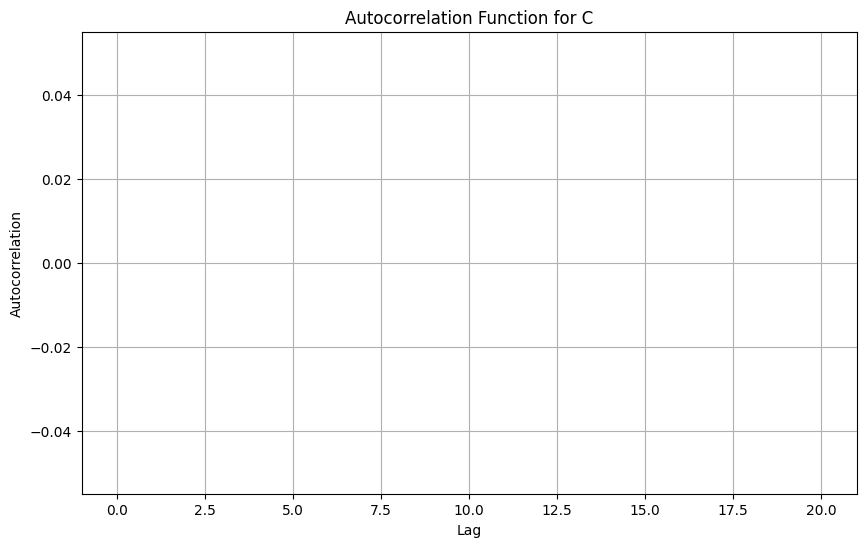

Estimated Autocorrelation Time: nan


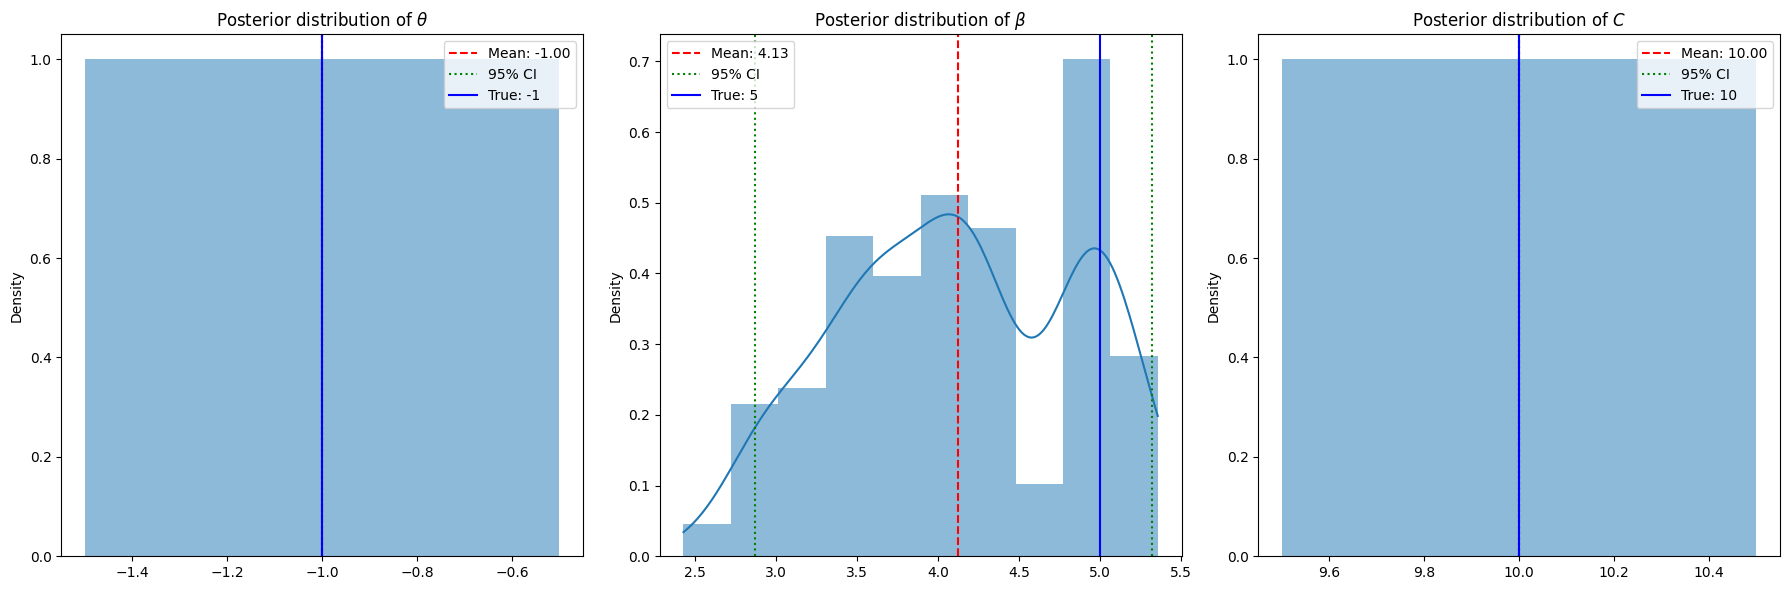

In [5]:
from JIT_accelerated_code import *
from tqdm import tqdm
import seaborn as sns
#Again, we first generate the noisy observations.
#We again have the noisy data first:
#Again, we first generate the noisy observations.
#We again have the noisy data first:


#beta_pcn = 1 #The step parameter for the pre-conditioned crank nicolson algorithm
n_iter = 300 #Number of iterations
theta0 = -1 #Initial guess of theta
beta0 = 5 #Initial Guess of beta
C0 = 10  #Initial Guess of C  
num_particles = 1000

#The 3 step sizes for the 3 parameters
l_theta = 1 
l_beta = 0.2
l_C = 2





true_theta = -1 #The true theta value for the Langevin system


kw = 1 #The prior parameter for muw

kv = 0.001 #The observation noise scaling factor. Note that this scaling factor applies to the variance
true_sigmaw = 0.2
true_muw = 0.2
sigma_n = true_sigmaw * np.sqrt(kv)


#Simulation Parameters

true_beta = 5
true_C = 10
T = 30


N = 10 * T  # Resolution, 10 points per unit time now

#Define the Langevin dynamics
A = np.zeros((2, 2))
A[0, 1] = 1
A[1, 1] = true_theta
h = np.array([[0], [1]])

#Simulation
evaluation_points = np.linspace(0, T, N) #Note that this would be the time axis we work on.
normal_gamma_generator = normal_gamma_process(true_beta, true_C, T, true_muw, true_sigmaw)
langevin = SDE(A,h,T,normal_gamma_generator)
#Noisy observation generation
SDE_samples,system_jumps,NVM_jumps,subordinator_jumps,jump_times = langevin.generate_samples(evaluation_points,all_data=True)
d1,d2 = np.shape(SDE_samples)
#Noisy_samples = SDE_samples + np.random.randn(d1,d2)*sigma_n #The noisy observations simulated. Already in the column vector form


#Create the partial observation, observing only the integral state x here.
Noisy_samples = SDE_samples[:,0] + np.random.randn(np.shape(SDE_samples)[0])*sigma_n #The noisy observations simulated. Already in the column vector form


#The collection of the parameter samples
theta_samples = [theta0]
C_samples = [C0]
beta_samples = [beta0]
first_time = True

for iter in tqdm(range(n_iter), desc="Processing"):



    if first_time:
        #print("Progress:",progress/searching_resolution, "%")
        #progress +=1
        #Prior inverted gamma parameters for sigmaw
        alphaws = 2.1 * np.ones(num_particles)
        betaws = 1 * np.ones(num_particles)
        accumulated_Es = np.zeros(num_particles)
        accumulated_Fs = np.zeros(num_particles)

        trajectory = []
        A = np.zeros((2, 2))
        A[0, 1] = 1
        A[1, 1] = theta_samples[-1]

        #Kalman filter initialisation
        X0 = Noisy_samples[0]
        nx0 = 2
        X0 = np.zeros((nx0+1,1))
        nx0_new = 3

        #The margianlised Kalman covariance
        C_prior = np.zeros((nx0_new,nx0_new))
        C_prior[-1,-1] = kw

        g = np.array([[1],[0],[0]])
        g = g.T
        R = np.array([kv]) #The noise covariance matrix. Same observation noise throughout




        #Particle filter Initialisation    
        initial_particles = []
        for i in range(num_particles):
            initial_particles.append([np.zeros((nx0,1)),np.eye(nx0)])
        previous_Xs = []
        previous_X_uncertaintys = []
        for i in range(num_particles):
            previous_X_uncertaintys.append(C_prior)
            previous_Xs.append(X0)
        # Define initial weights (uniform)
        initial_weights = np.ones(num_particles) / num_particles

        

        # Time step size and sigma for the likelihood function
        dt = evaluation_points[1] - evaluation_points[0]
        matrix_exp = expm(A*dt)
        sigma = sigma_n #The observatin noise



        #Containers for the imnference results
        inferred_Xs = []
        inferred_covs = []
        first_time = True

        # Running the particle filter
        particles = initial_particles
        histories = [particles]
        weights = initial_weights




        sigmaw_values = []
        

        

        for i in range(len(evaluation_points)): #i is the time index we want for N
            #sigmaw here needs to be updated in every step
            sigmaw2,sigmaw2_uncertainty = inverted_gamma_to_mean_variance(alphaws, betaws,weights) #Note that this is sigmaw^2 but not sigmaw
            sigmaw = np.sqrt(sigmaw2)

            sigmaw_values.append(sigmaw)
            


            incremental_normal_gamma_generator = normal_gamma_process(beta_samples[-1], C_samples[-1], dt, 0, sigmaw) #We are just using the built in gamma generator inside， putting in some random muw or sigmaw has no effect
            incremental_SDE = SDE(A,h,dt,incremental_normal_gamma_generator)
            #print(i)
            t = evaluation_points[i]
            observation = Noisy_samples[i] #Note that the observation here is still a row vector, reshaping necessary
            previous_Xs, previous_X_uncertaintys,particles,weights,alphaws, betaws, accumulated_Es, accumulated_Fs,log_marginals  = ultimate_NVM_pf(observation, previous_Xs, previous_X_uncertaintys, particles, transition_function_ultimate_NVM_pf, matrix_exp, dt,incremental_SDE,g,R,alphaws,betaws,accumulated_Es,accumulated_Fs,i,return_log_marginals=True) # N is the time nidex
            inferred_cov = weighted_sum(previous_X_uncertaintys,weights) * sigmaw2 #Note that the original parameters are marginalised by sigmaw^2
            inferred_X = weighted_sum(previous_Xs,weights)
            
            histories.append(particles)
            
            inferred_Xs.append(inferred_X)
            inferred_covs.append(inferred_cov)
            log_marginals = np.array(log_marginals)

        original_state_log_probability = logsumexp(log_marginals) - np.log(num_particles)
        first_time = False





    #####################################################################################################################################################################################################################################################
    #From here, we propose a the parameter samples, indepndent parameter assumed

    theta_proposed = theta0
    beta_proposed = beta_samples[-1] + np.random.randn() * l_beta
    C_proposed = C0
    #Note that the Gamma process parameters have to be positive
    if beta_proposed <=0:
        beta_proposed = 0.000001
    if C_proposed <= 0:
        C_proposeed = 0.000001
    #print("Progress:",progress/searching_resolution, "%")
    #progress +=1
    #Prior inverted gamma parameters for sigmaw
    alphaws = 2.1 * np.ones(num_particles)
    betaws = 1 * np.ones(num_particles)
    accumulated_Es = np.zeros(num_particles)
    accumulated_Fs = np.zeros(num_particles)

    trajectory = []
    A = np.zeros((2, 2))
    A[0, 1] = 1
    A[1, 1] = theta_proposed

    #Kalman filter initialisation
    X0 = Noisy_samples[0]
    nx0 = 2
    X0 = np.zeros((nx0+1,1))
    nx0_new = 3

    #The margianlised Kalman covariance
    C_prior = np.zeros((nx0_new,nx0_new))
    C_prior[-1,-1] = kw

    g = np.array([[1],[0],[0]])
    g = g.T
    R = np.array([kv]) #The noise covariance matrix. Same observation noise throughout




    #Particle filter Initialisation    
    initial_particles = []
    for i in range(num_particles):
        initial_particles.append([np.zeros((nx0,1)),np.eye(nx0)])
    previous_Xs = []
    previous_X_uncertaintys = []
    for i in range(num_particles):
        previous_X_uncertaintys.append(C_prior)
        previous_Xs.append(X0)
    # Define initial weights (uniform)
    initial_weights = np.ones(num_particles) / num_particles

    

    # Time step size and sigma for the likelihood function
    dt = evaluation_points[1] - evaluation_points[0]
    matrix_exp = expm(A*dt)
    sigma = sigma_n #The observatin noise



    #Containers for the imnference results
    inferred_Xs = []
    inferred_covs = []
    first_time = True

    # Running the particle filter
    particles = initial_particles
    histories = [particles]
    weights = initial_weights




    sigmaw_values = []
    

    for i in range(len(evaluation_points)): #i is the time index we want for N
        #sigmaw here needs to be updated in every step
        sigmaw2,sigmaw2_uncertainty = inverted_gamma_to_mean_variance(alphaws, betaws,weights)
        sigmaw = np.sqrt(sigmaw2)

        sigmaw_values.append(sigmaw)
       


        incremental_normal_gamma_generator = normal_gamma_process(beta_proposed, C_proposed, dt, 0, sigmaw) #We are just using the built in gamma generator inside， putting in some random muw or sigmaw has no effect
        incremental_SDE = SDE(A,h,dt,incremental_normal_gamma_generator)
        #print(i)
        t = evaluation_points[i]
        observation = Noisy_samples[i] #Note that the observation here is still a row vector, reshaping necessary
        previous_Xs, previous_X_uncertaintys,particles,weights,alphaws, betaws, accumulated_Es, accumulated_Fs,log_marginals  = ultimate_NVM_pf(observation, previous_Xs, previous_X_uncertaintys, particles, transition_function_ultimate_NVM_pf, matrix_exp, dt,incremental_SDE,g,R,alphaws,betaws,accumulated_Es,accumulated_Fs,i,return_log_marginals=True) # N is the time nidex
        inferred_cov = weighted_sum(previous_X_uncertaintys,weights) * sigmaw2 #Note that the original parameters are marginalised by sigmaw^2
        inferred_X = weighted_sum(previous_Xs,weights)
        
        histories.append(particles)
        
        inferred_Xs.append(inferred_X)
        inferred_covs.append(inferred_cov)
        log_marginals = np.array(log_marginals)

    proposed_state_log_probability = logsumexp(log_marginals) - np.log(num_particles)


    ##################################################################################################################################################################################################################################
    # Acceptance Attempt
    log_acceptance_ratio = proposed_state_log_probability - original_state_log_probability
    if np.log(np.random.rand())< log_acceptance_ratio: #Accepted case
        theta_samples.append(theta_proposed)
        beta_samples.append(beta_proposed)
        C_samples.append(C_proposed)
        original_state_log_probability = proposed_state_log_probability
    else: #Rejected case
        theta_samples.append(theta_samples[-1])
        beta_samples.append(beta_samples[-1])
        C_samples.append(C_samples[-1])


theta_samples = np.array(theta_samples)  # 假设已经去除了燃烧期的样本
beta_samples = np.array(beta_samples)
C_samples = np.array(C_samples)

# 后验分布摘要 for theta
mean_theta = np.mean(theta_samples)
median_theta = np.median(theta_samples)
conf_interval = np.percentile(theta_samples, [2.5, 97.5])  # 95%置信区间

plt.figure(figsize=(10, 6))
plt.plot(theta_samples)
plt.xlabel("Iteration Number")
plt.ylabel("Theta Value")
plt.title("Theta Samples from PMMH")
plt.show()


# 打印摘要统计量
print(f"Mean of theta: {mean_theta}")
print(f"Median of theta: {median_theta}")
print(f"95% confidence interval of theta: {conf_interval}")


plot_autocorrelation(theta_samples,parameter_name = "Theta")


# 后验分布摘要 for beta
mean_beta = np.mean(beta_samples)
median_beta = np.median(beta_samples)
conf_interval = np.percentile(beta_samples, [2.5, 97.5])  # 95%置信区间

plt.figure(figsize=(10, 6))
plt.plot(beta_samples)
plt.xlabel("Iteration Number")
plt.ylabel("Beta Value")
plt.title("Beta Samples from PMMH")
plt.show()


# 打印摘要统计量
print(f"Mean of beta: {mean_beta}")
print(f"Median of beta: {median_beta}")
print(f"95% confidence interval of beta: {conf_interval}")

plot_autocorrelation(beta_samples, parameter_name="Beta")


# 后验分布摘要
mean_C = np.mean(C_samples)
median_C = np.median(C_samples)
conf_interval = np.percentile(C_samples, [2.5, 97.5])  # 95%置信区间

plt.figure(figsize=(10, 6))
plt.plot(C_samples)
plt.xlabel("Iteration Number")
plt.ylabel("C Value")
plt.title("C Samples from PMMH")
plt.show()


# 打印摘要统计量
print(f"Mean of C: {mean_C}")
print(f"Median of C: {median_C}")
print(f"95% confidence interval of C: {conf_interval}")

plot_autocorrelation(C_samples, parameter_name="C")





# 后验分布摘要和可视化
plt.figure(figsize=(18, 6))

# Theta
plt.subplot(1, 3, 1)
sns.histplot(theta_samples, kde=True, stat="density", linewidth=0)
plt.axvline(np.mean(theta_samples), color='r', linestyle='--', label=f'Mean: {np.mean(theta_samples):.2f}')
plt.axvline(np.percentile(theta_samples, 2.5), color='g', linestyle=':', label='95% CI')
plt.axvline(np.percentile(theta_samples, 97.5), color='g', linestyle=':')
plt.axvline(true_theta, color='blue', linestyle='-', label=f'True: {true_theta}')
plt.title('Posterior distribution of $\\theta$')
plt.legend()

# Beta
plt.subplot(1, 3, 2)
sns.histplot(beta_samples, kde=True, stat="density", linewidth=0)
plt.axvline(np.mean(beta_samples), color='r', linestyle='--', label=f'Mean: {np.mean(beta_samples):.2f}')
plt.axvline(np.percentile(beta_samples, 2.5), color='g', linestyle=':', label='95% CI')
plt.axvline(np.percentile(beta_samples, 97.5), color='g', linestyle=':')
plt.axvline(true_beta, color='blue', linestyle='-', label=f'True: {true_beta}')
plt.title('Posterior distribution of $\\beta$')
plt.legend()

# C
plt.subplot(1, 3, 3)
sns.histplot(C_samples, kde=True, stat="density", linewidth=0)
plt.axvline(np.mean(C_samples), color='r', linestyle='--', label=f'Mean: {np.mean(C_samples):.2f}')
plt.axvline(np.percentile(C_samples, 2.5), color='g', linestyle=':', label='95% CI')
plt.axvline(np.percentile(C_samples, 97.5), color='g', linestyle=':')
plt.axvline(true_C, color='blue', linestyle='-', label=f'True: {true_C}')
plt.title('Posterior distribution of $C$')
plt.legend()

plt.tight_layout()
plt.show()



# C Search

Processing: 100%|██████████| 300/300 [6:56:43<00:00, 83.34s/it]  


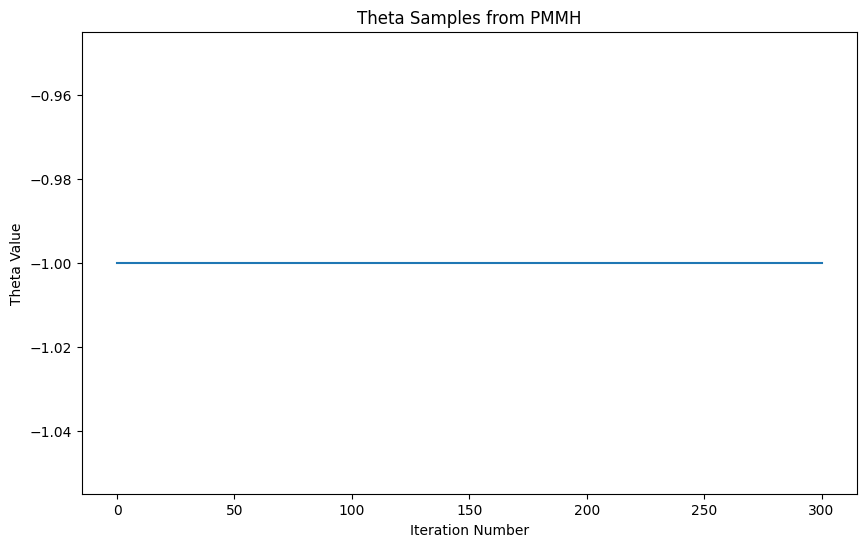

e:\Cambridge\Year 4\Fourth Year Projcet\IIB_Codes\JIT_accelerated_code.py:66: RuntimeWarning: divide by zero encountered in divide
  acf = np.correlate(samples - mean, samples - mean, mode='full')[n-1:] / (var*n)
e:\Cambridge\Year 4\Fourth Year Projcet\IIB_Codes\JIT_accelerated_code.py:66: RuntimeWarning: invalid value encountered in divide
  acf = np.correlate(samples - mean, samples - mean, mode='full')[n-1:] / (var*n)
e:\Cambridge\Year 4\Fourth Year Projcet\source_code\y4proj_env\Lib\site-packages\matplotlib\axes\_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


Mean of theta: -1.0
Median of theta: -1.0
95% confidence interval of theta: [-1. -1.]


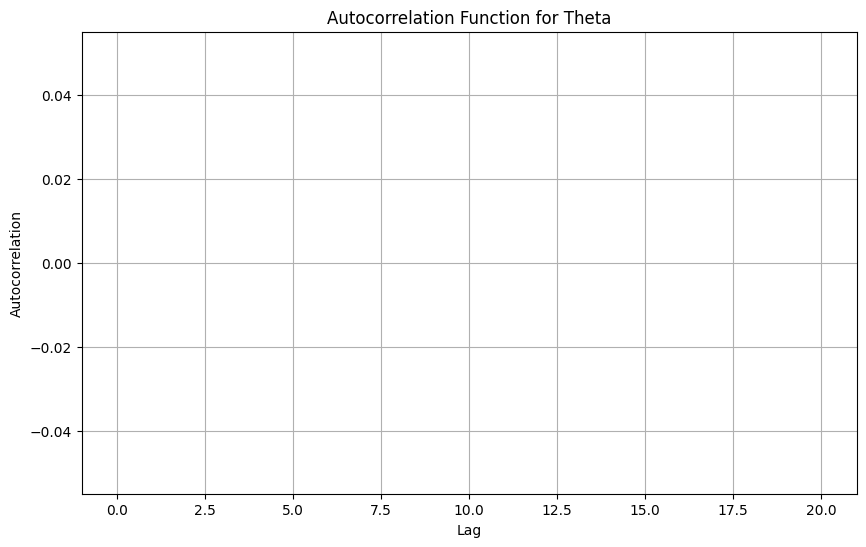

Estimated Autocorrelation Time: nan


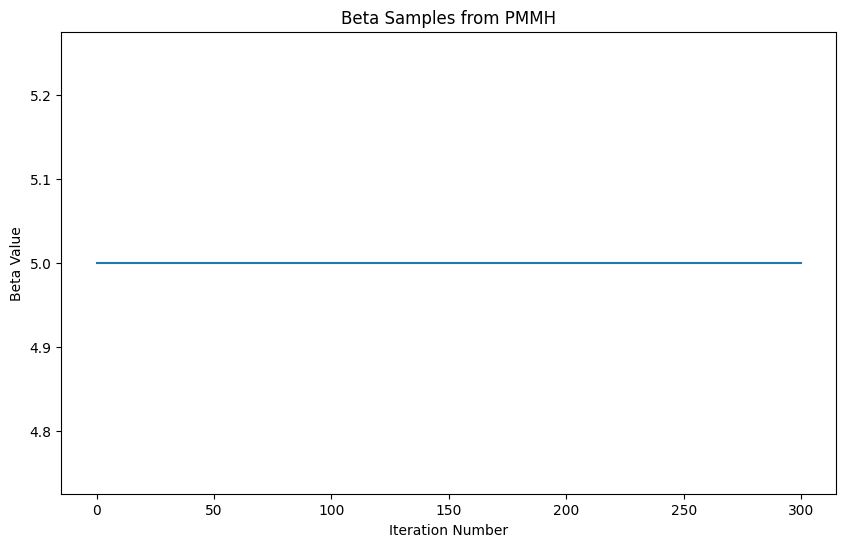

Mean of beta: 5.0
Median of beta: 5.0
95% confidence interval of beta: [5. 5.]


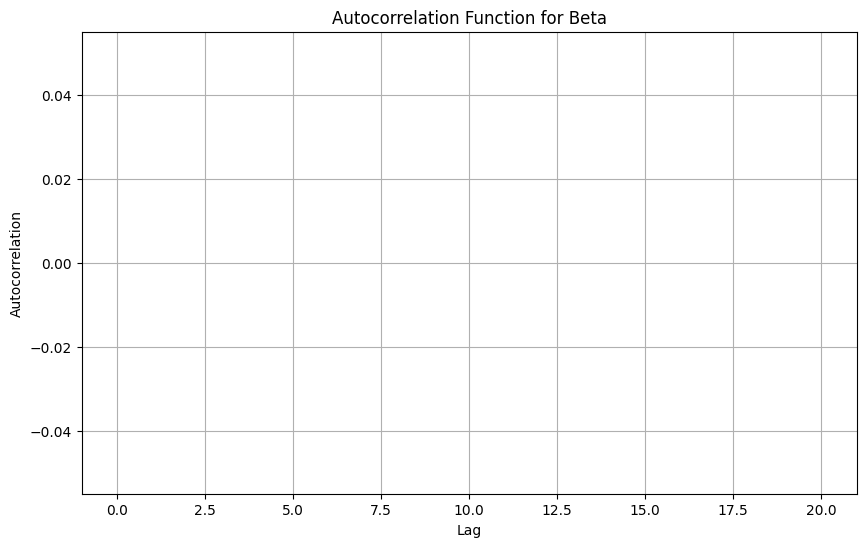

Estimated Autocorrelation Time: nan


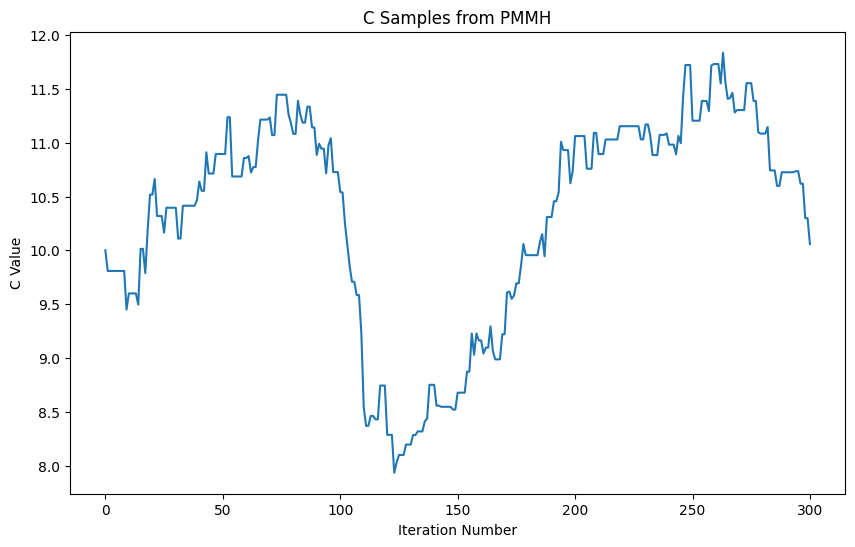

Mean of C: 10.313728738847074
Median of C: 10.713678015032974
95% confidence interval of C: [ 8.23942256 11.63984656]


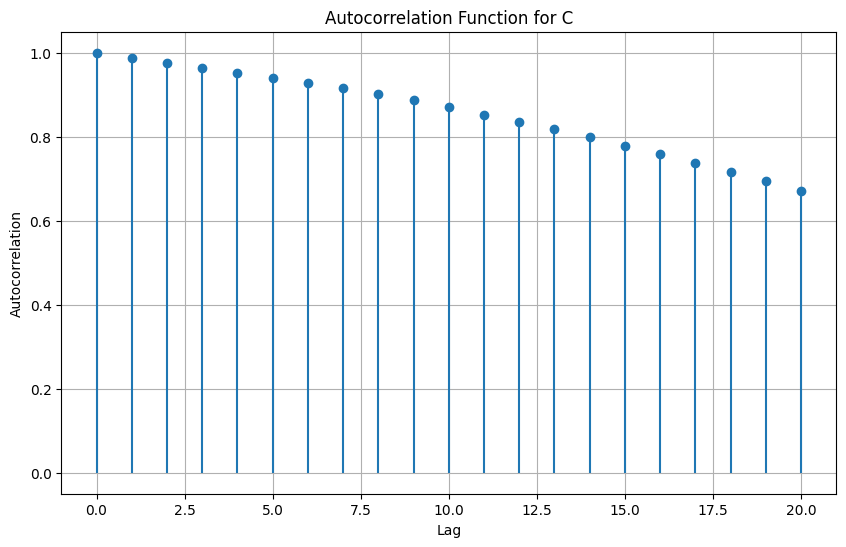

Estimated Autocorrelation Time: 34.9666277432815


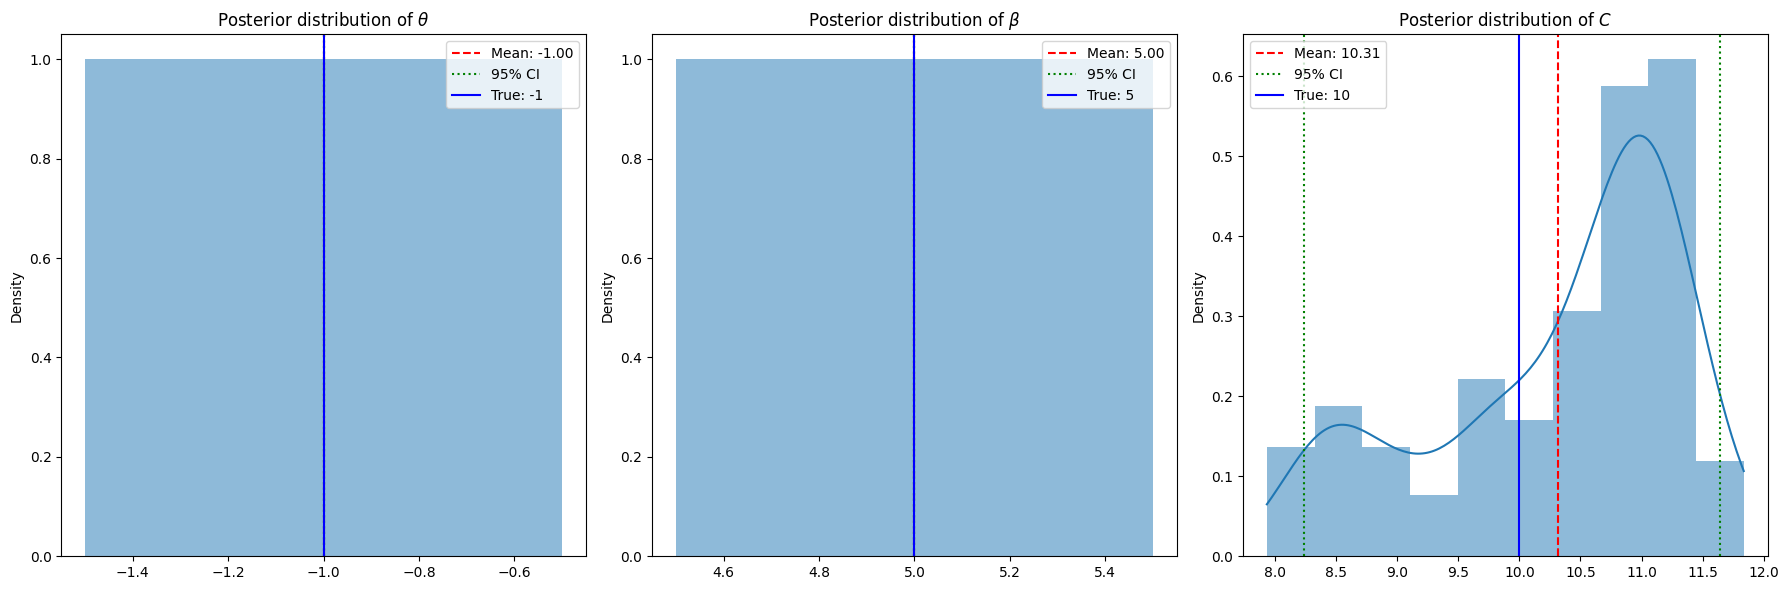

In [4]:
from JIT_accelerated_code import *
from tqdm import tqdm
import seaborn as sns
#Again, we first generate the noisy observations.
#We again have the noisy data first:
#Again, we first generate the noisy observations.
#We again have the noisy data first:


#beta_pcn = 1 #The step parameter for the pre-conditioned crank nicolson algorithm
n_iter = 300 #Number of iterations
theta0 = -1 #Initial guess of theta
beta0 = 5 #Initial Guess of beta
C0 = 10  #Initial Guess of C  
num_particles = 1000

#The 3 step sizes for the 3 parameters
l_theta = 1 
l_beta = 2
l_C = 0.2





true_theta = -1 #The true theta value for the Langevin system


kw = 1 #The prior parameter for muw

kv = 0.001 #The observation noise scaling factor. Note that this scaling factor applies to the variance
true_sigmaw = 2
true_muw = 0.2
sigma_n = true_sigmaw * np.sqrt(kv)


#Simulation Parameters

true_beta = 5
true_C = 10
T = 30


N = 10 * T  # Resolution, 10 points per unit time now

#Define the Langevin dynamics
A = np.zeros((2, 2))
A[0, 1] = 1
A[1, 1] = true_theta
h = np.array([[0], [1]])

#Simulation
evaluation_points = np.linspace(0, T, N) #Note that this would be the time axis we work on.
normal_gamma_generator = normal_gamma_process(true_beta, true_C, T, true_muw, true_sigmaw)
langevin = SDE(A,h,T,normal_gamma_generator)
#Noisy observation generation
SDE_samples,system_jumps,NVM_jumps,subordinator_jumps,jump_times = langevin.generate_samples(evaluation_points,all_data=True)
d1,d2 = np.shape(SDE_samples)
#Noisy_samples = SDE_samples + np.random.randn(d1,d2)*sigma_n #The noisy observations simulated. Already in the column vector form


#Create the partial observation, observing only the integral state x here.
Noisy_samples = SDE_samples[:,0] + np.random.randn(np.shape(SDE_samples)[0])*sigma_n #The noisy observations simulated. Already in the column vector form


#The collection of the parameter samples
theta_samples = [theta0]
C_samples = [C0]
beta_samples = [beta0]
first_time = True

for iter in tqdm(range(n_iter), desc="Processing"):



    if first_time:
        #print("Progress:",progress/searching_resolution, "%")
        #progress +=1
        #Prior inverted gamma parameters for sigmaw
        alphaws = 2.1 * np.ones(num_particles)
        betaws = 1 * np.ones(num_particles)
        accumulated_Es = np.zeros(num_particles)
        accumulated_Fs = np.zeros(num_particles)

        trajectory = []
        A = np.zeros((2, 2))
        A[0, 1] = 1
        A[1, 1] = theta_samples[-1]

        #Kalman filter initialisation
        X0 = Noisy_samples[0]
        nx0 = 2
        X0 = np.zeros((nx0+1,1))
        nx0_new = 3

        #The margianlised Kalman covariance
        C_prior = np.zeros((nx0_new,nx0_new))
        C_prior[-1,-1] = kw

        g = np.array([[1],[0],[0]])
        g = g.T
        R = np.array([kv]) #The noise covariance matrix. Same observation noise throughout




        #Particle filter Initialisation    
        initial_particles = []
        for i in range(num_particles):
            initial_particles.append([np.zeros((nx0,1)),np.eye(nx0)])
        previous_Xs = []
        previous_X_uncertaintys = []
        for i in range(num_particles):
            previous_X_uncertaintys.append(C_prior)
            previous_Xs.append(X0)
        # Define initial weights (uniform)
        initial_weights = np.ones(num_particles) / num_particles

        

        # Time step size and sigma for the likelihood function
        dt = evaluation_points[1] - evaluation_points[0]
        matrix_exp = expm(A*dt)
        sigma = sigma_n #The observatin noise



        #Containers for the imnference results
        inferred_Xs = []
        inferred_covs = []
        first_time = True

        # Running the particle filter
        particles = initial_particles
        histories = [particles]
        weights = initial_weights




        sigmaw_values = []
        

        

        for i in range(len(evaluation_points)): #i is the time index we want for N
            #sigmaw here needs to be updated in every step
            sigmaw2,sigmaw2_uncertainty = inverted_gamma_to_mean_variance(alphaws, betaws,weights) #Note that this is sigmaw^2 but not sigmaw
            sigmaw = np.sqrt(sigmaw2)

            sigmaw_values.append(sigmaw)
            


            incremental_normal_gamma_generator = normal_gamma_process(beta_samples[-1], C_samples[-1], dt, 0, sigmaw) #We are just using the built in gamma generator inside， putting in some random muw or sigmaw has no effect
            incremental_SDE = SDE(A,h,dt,incremental_normal_gamma_generator)
            #print(i)
            t = evaluation_points[i]
            observation = Noisy_samples[i] #Note that the observation here is still a row vector, reshaping necessary
            previous_Xs, previous_X_uncertaintys,particles,weights,alphaws, betaws, accumulated_Es, accumulated_Fs,log_marginals  = ultimate_NVM_pf(observation, previous_Xs, previous_X_uncertaintys, particles, transition_function_ultimate_NVM_pf, matrix_exp, dt,incremental_SDE,g,R,alphaws,betaws,accumulated_Es,accumulated_Fs,i,return_log_marginals=True) # N is the time nidex
            inferred_cov = weighted_sum(previous_X_uncertaintys,weights) * sigmaw2 #Note that the original parameters are marginalised by sigmaw^2
            inferred_X = weighted_sum(previous_Xs,weights)
            
            histories.append(particles)
            
            inferred_Xs.append(inferred_X)
            inferred_covs.append(inferred_cov)
            log_marginals = np.array(log_marginals)

        original_state_log_probability = logsumexp(log_marginals) - np.log(num_particles)
        first_time = False





    #####################################################################################################################################################################################################################################################
    #From here, we propose a the parameter samples, indepndent parameter assumed

    theta_proposed = theta0
    beta_proposed = beta0
    C_proposed = C_samples[-1] + np.random.randn() * l_C
    #Note that the Gamma process parameters have to be positive
    if beta_proposed <=0:
        beta_proposed = 0.000001
    if C_proposed <= 0:
        C_proposeed = 0.000001
    #print("Progress:",progress/searching_resolution, "%")
    #progress +=1
    #Prior inverted gamma parameters for sigmaw
    alphaws = 2.1 * np.ones(num_particles)
    betaws = 1 * np.ones(num_particles)
    accumulated_Es = np.zeros(num_particles)
    accumulated_Fs = np.zeros(num_particles)

    trajectory = []
    A = np.zeros((2, 2))
    A[0, 1] = 1
    A[1, 1] = theta_proposed

    #Kalman filter initialisation
    X0 = Noisy_samples[0]
    nx0 = 2
    X0 = np.zeros((nx0+1,1))
    nx0_new = 3

    #The margianlised Kalman covariance
    C_prior = np.zeros((nx0_new,nx0_new))
    C_prior[-1,-1] = kw

    g = np.array([[1],[0],[0]])
    g = g.T
    R = np.array([kv]) #The noise covariance matrix. Same observation noise throughout




    #Particle filter Initialisation    
    initial_particles = []
    for i in range(num_particles):
        initial_particles.append([np.zeros((nx0,1)),np.eye(nx0)])
    previous_Xs = []
    previous_X_uncertaintys = []
    for i in range(num_particles):
        previous_X_uncertaintys.append(C_prior)
        previous_Xs.append(X0)
    # Define initial weights (uniform)
    initial_weights = np.ones(num_particles) / num_particles

    

    # Time step size and sigma for the likelihood function
    dt = evaluation_points[1] - evaluation_points[0]
    matrix_exp = expm(A*dt)
    sigma = sigma_n #The observatin noise



    #Containers for the imnference results
    inferred_Xs = []
    inferred_covs = []
    first_time = True

    # Running the particle filter
    particles = initial_particles
    histories = [particles]
    weights = initial_weights




    sigmaw_values = []
    

    for i in range(len(evaluation_points)): #i is the time index we want for N
        #sigmaw here needs to be updated in every step
        sigmaw2,sigmaw2_uncertainty = inverted_gamma_to_mean_variance(alphaws, betaws,weights)
        sigmaw = np.sqrt(sigmaw2)

        sigmaw_values.append(sigmaw)
       


        incremental_normal_gamma_generator = normal_gamma_process(beta_proposed, C_proposed, dt, 0, sigmaw) #We are just using the built in gamma generator inside， putting in some random muw or sigmaw has no effect
        incremental_SDE = SDE(A,h,dt,incremental_normal_gamma_generator)
        #print(i)
        t = evaluation_points[i]
        observation = Noisy_samples[i] #Note that the observation here is still a row vector, reshaping necessary
        previous_Xs, previous_X_uncertaintys,particles,weights,alphaws, betaws, accumulated_Es, accumulated_Fs,log_marginals  = ultimate_NVM_pf(observation, previous_Xs, previous_X_uncertaintys, particles, transition_function_ultimate_NVM_pf, matrix_exp, dt,incremental_SDE,g,R,alphaws,betaws,accumulated_Es,accumulated_Fs,i,return_log_marginals=True) # N is the time nidex
        inferred_cov = weighted_sum(previous_X_uncertaintys,weights) * sigmaw2 #Note that the original parameters are marginalised by sigmaw^2
        inferred_X = weighted_sum(previous_Xs,weights)
        
        histories.append(particles)
        
        inferred_Xs.append(inferred_X)
        inferred_covs.append(inferred_cov)
        log_marginals = np.array(log_marginals)

    proposed_state_log_probability = logsumexp(log_marginals) - np.log(num_particles)


    ##################################################################################################################################################################################################################################
    # Acceptance Attempt
    log_acceptance_ratio = proposed_state_log_probability - original_state_log_probability
    if np.log(np.random.rand())< log_acceptance_ratio: #Accepted case
        theta_samples.append(theta_proposed)
        beta_samples.append(beta_proposed)
        C_samples.append(C_proposed)
        original_state_log_probability = proposed_state_log_probability
    else: #Rejected case
        theta_samples.append(theta_samples[-1])
        beta_samples.append(beta_samples[-1])
        C_samples.append(C_samples[-1])


theta_samples = np.array(theta_samples)  # 假设已经去除了燃烧期的样本
beta_samples = np.array(beta_samples)
C_samples = np.array(C_samples)

# 后验分布摘要 for theta
mean_theta = np.mean(theta_samples)
median_theta = np.median(theta_samples)
conf_interval = np.percentile(theta_samples, [2.5, 97.5])  # 95%置信区间

plt.figure(figsize=(10, 6))
plt.plot(theta_samples)
plt.xlabel("Iteration Number")
plt.ylabel("Theta Value")
plt.title("Theta Samples from PMMH")
plt.show()


# 打印摘要统计量
print(f"Mean of theta: {mean_theta}")
print(f"Median of theta: {median_theta}")
print(f"95% confidence interval of theta: {conf_interval}")


plot_autocorrelation(theta_samples,parameter_name = "Theta")


# 后验分布摘要 for beta
mean_beta = np.mean(beta_samples)
median_beta = np.median(beta_samples)
conf_interval = np.percentile(beta_samples, [2.5, 97.5])  # 95%置信区间

plt.figure(figsize=(10, 6))
plt.plot(beta_samples)
plt.xlabel("Iteration Number")
plt.ylabel("Beta Value")
plt.title("Beta Samples from PMMH")
plt.show()


# 打印摘要统计量
print(f"Mean of beta: {mean_beta}")
print(f"Median of beta: {median_beta}")
print(f"95% confidence interval of beta: {conf_interval}")

plot_autocorrelation(beta_samples, parameter_name="Beta")


# 后验分布摘要
mean_C = np.mean(C_samples)
median_C = np.median(C_samples)
conf_interval = np.percentile(C_samples, [2.5, 97.5])  # 95%置信区间

plt.figure(figsize=(10, 6))
plt.plot(C_samples)
plt.xlabel("Iteration Number")
plt.ylabel("C Value")
plt.title("C Samples from PMMH")
plt.show()


# 打印摘要统计量
print(f"Mean of C: {mean_C}")
print(f"Median of C: {median_C}")
print(f"95% confidence interval of C: {conf_interval}")

plot_autocorrelation(C_samples, parameter_name="C")





# 后验分布摘要和可视化
plt.figure(figsize=(18, 6))

# Theta
plt.subplot(1, 3, 1)
sns.histplot(theta_samples, kde=True, stat="density", linewidth=0)
plt.axvline(np.mean(theta_samples), color='r', linestyle='--', label=f'Mean: {np.mean(theta_samples):.2f}')
plt.axvline(np.percentile(theta_samples, 2.5), color='g', linestyle=':', label='95% CI')
plt.axvline(np.percentile(theta_samples, 97.5), color='g', linestyle=':')
plt.axvline(true_theta, color='blue', linestyle='-', label=f'True: {true_theta}')
plt.title('Posterior distribution of $\\theta$')
plt.legend()

# Beta
plt.subplot(1, 3, 2)
sns.histplot(beta_samples, kde=True, stat="density", linewidth=0)
plt.axvline(np.mean(beta_samples), color='r', linestyle='--', label=f'Mean: {np.mean(beta_samples):.2f}')
plt.axvline(np.percentile(beta_samples, 2.5), color='g', linestyle=':', label='95% CI')
plt.axvline(np.percentile(beta_samples, 97.5), color='g', linestyle=':')
plt.axvline(true_beta, color='blue', linestyle='-', label=f'True: {true_beta}')
plt.title('Posterior distribution of $\\beta$')
plt.legend()

# C
plt.subplot(1, 3, 3)
sns.histplot(C_samples, kde=True, stat="density", linewidth=0)
plt.axvline(np.mean(C_samples), color='r', linestyle='--', label=f'Mean: {np.mean(C_samples):.2f}')
plt.axvline(np.percentile(C_samples, 2.5), color='g', linestyle=':', label='95% CI')
plt.axvline(np.percentile(C_samples, 97.5), color='g', linestyle=':')
plt.axvline(true_C, color='blue', linestyle='-', label=f'True: {true_C}')
plt.title('Posterior distribution of $C$')
plt.legend()

plt.tight_layout()
plt.show()



# $\theta$ Search

Processing: 100%|██████████| 300/300 [2:50:41<00:00, 34.14s/it]  


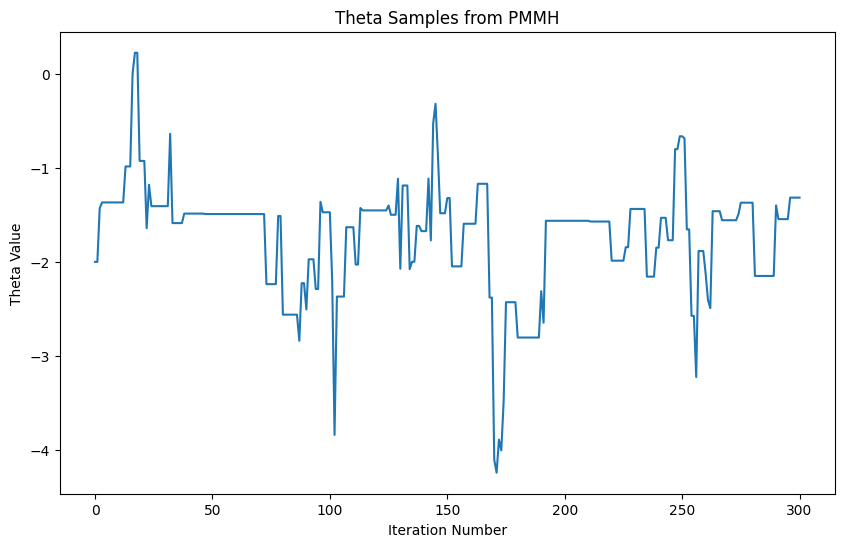

Mean of theta: -1.7198513681603351
Median of theta: -1.5635639288659675
95% confidence interval of theta: [-2.82090431 -0.67666325]


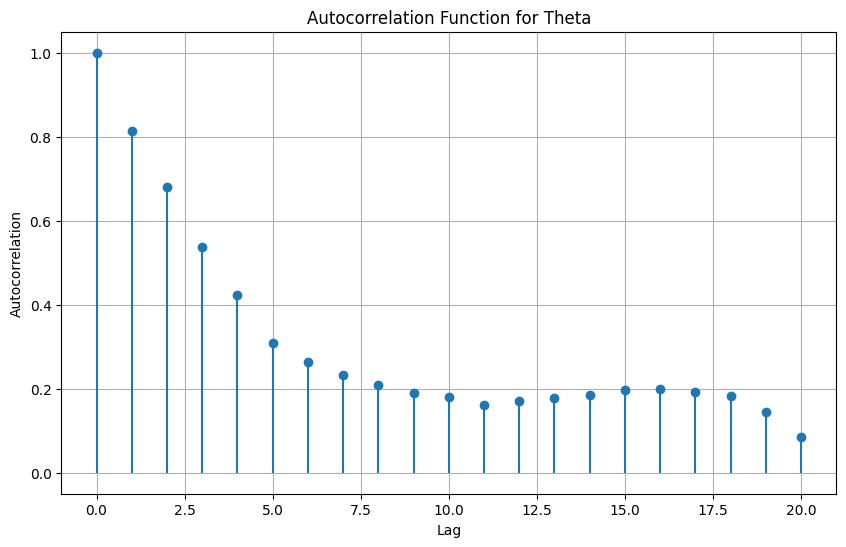

Estimated Autocorrelation Time: 12.075128455852234


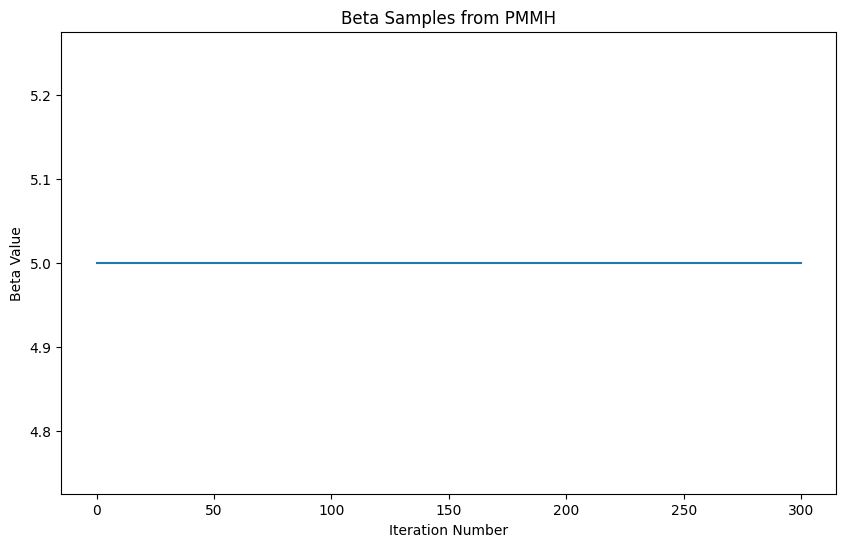

Mean of beta: 5.0
Median of beta: 5.0
95% confidence interval of beta: [5. 5.]


e:\Cambridge\Year 4\Fourth Year Projcet\IIB_Codes\JIT_accelerated_code.py:66: RuntimeWarning: divide by zero encountered in divide
  acf = np.correlate(samples - mean, samples - mean, mode='full')[n-1:] / (var*n)
e:\Cambridge\Year 4\Fourth Year Projcet\IIB_Codes\JIT_accelerated_code.py:66: RuntimeWarning: invalid value encountered in divide
  acf = np.correlate(samples - mean, samples - mean, mode='full')[n-1:] / (var*n)
e:\Cambridge\Year 4\Fourth Year Projcet\source_code\y4proj_env\Lib\site-packages\matplotlib\axes\_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


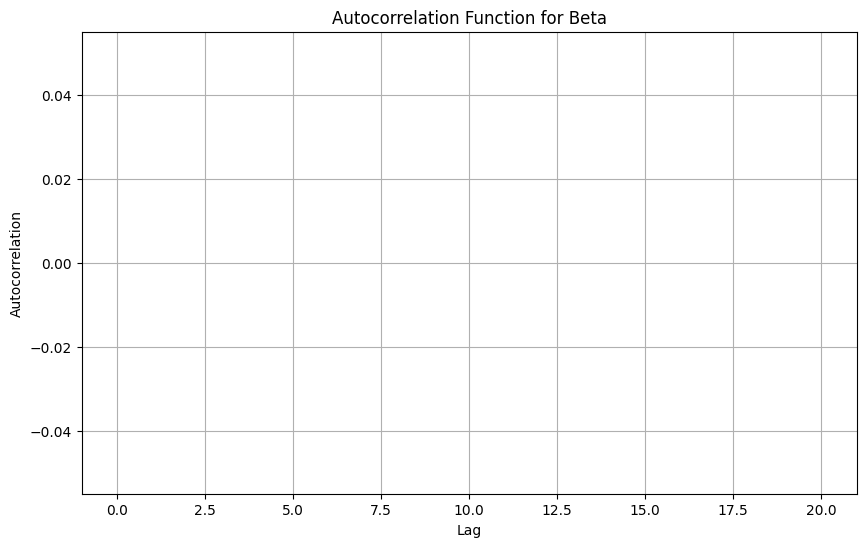

Estimated Autocorrelation Time: nan


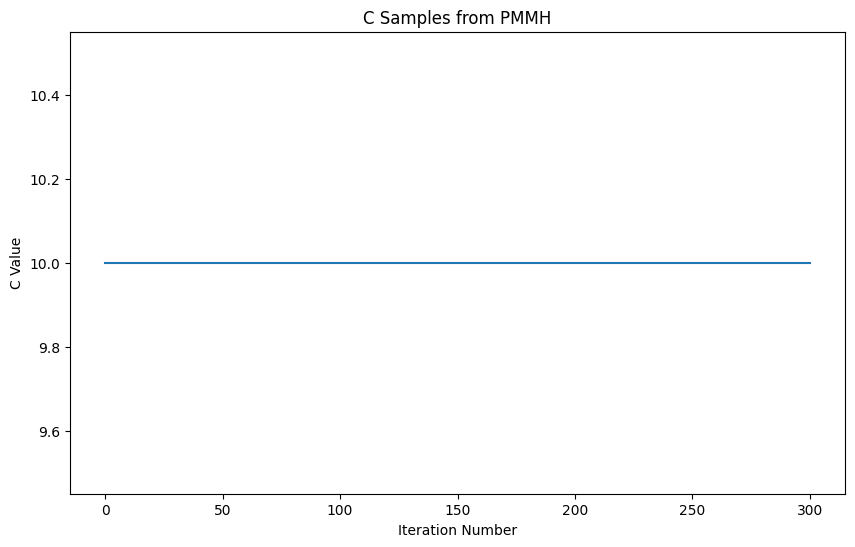

Mean of C: 10.0
Median of C: 10.0
95% confidence interval of C: [10. 10.]


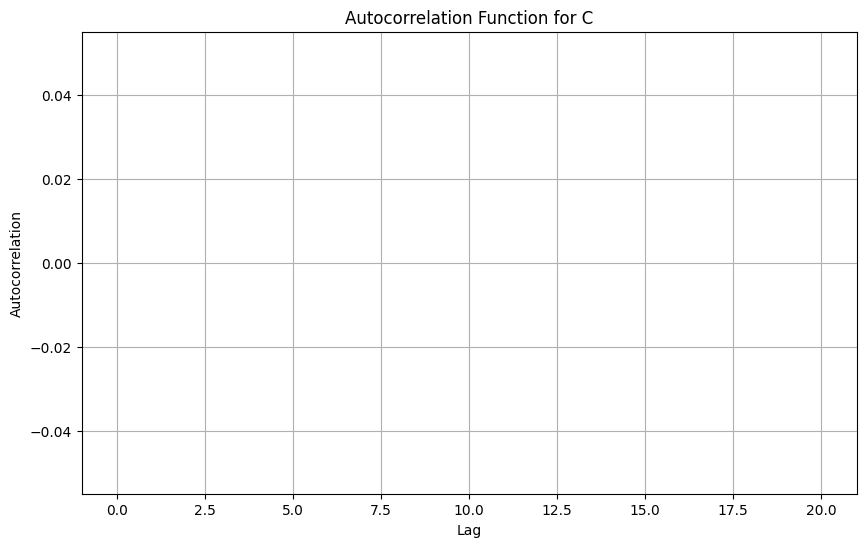

Estimated Autocorrelation Time: nan


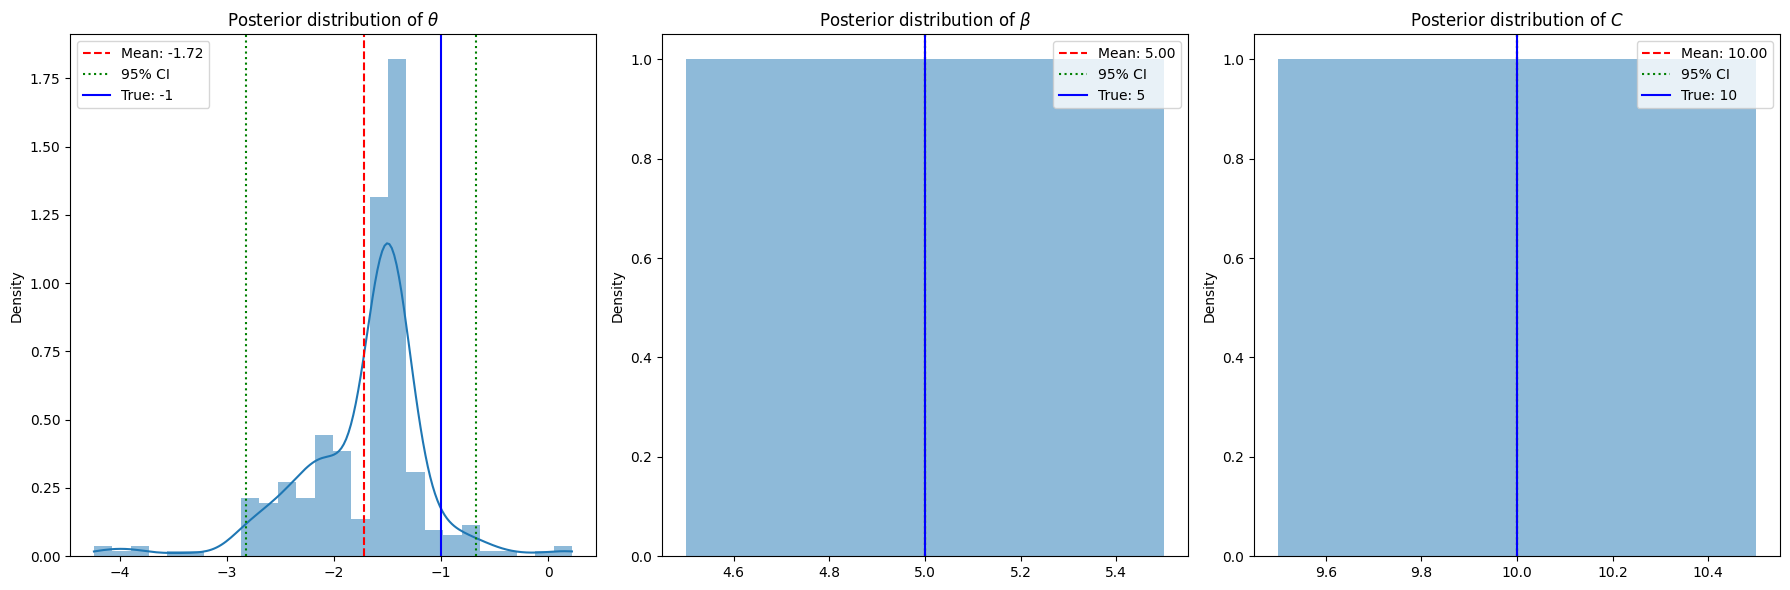

In [3]:
from JIT_accelerated_code import *
from tqdm import tqdm
import seaborn as sns
#Again, we first generate the noisy observations.
#We again have the noisy data first:
#Again, we first generate the noisy observations.
#We again have the noisy data first:


#beta_pcn = 1 #The step parameter for the pre-conditioned crank nicolson algorithm
n_iter = 300 #Number of iterations
theta0 = -2 #Initial guess of theta
beta0 = 5 #Initial Guess of beta
C0 = 10  #Initial Guess of C  
num_particles = 1000

#The 3 step sizes for the 3 parameters
l_theta = 1 
l_beta = 2
l_C = 2





true_theta = -1 #The true theta value for the Langevin system


kw = 1 #The prior parameter for muw

kv = 0.001 #The observation noise scaling factor. Note that this scaling factor applies to the variance
true_sigmaw = 2
true_muw = 0.2
sigma_n = true_sigmaw * np.sqrt(kv)


#Simulation Parameters

true_beta = 5
true_C = 10
T = 10


N = 10 * T  # Resolution, 10 points per unit time now

#Define the Langevin dynamics
A = np.zeros((2, 2))
A[0, 1] = 1
A[1, 1] = true_theta
h = np.array([[0], [1]])

#Simulation
evaluation_points = np.linspace(0, T, N) #Note that this would be the time axis we work on.
normal_gamma_generator = normal_gamma_process(true_beta, true_C, T, true_muw, true_sigmaw)
langevin = SDE(A,h,T,normal_gamma_generator)
#Noisy observation generation
SDE_samples,system_jumps,NVM_jumps,subordinator_jumps,jump_times = langevin.generate_samples(evaluation_points,all_data=True)
d1,d2 = np.shape(SDE_samples)
#Noisy_samples = SDE_samples + np.random.randn(d1,d2)*sigma_n #The noisy observations simulated. Already in the column vector form


#Create the partial observation, observing only the integral state x here.
Noisy_samples = SDE_samples[:,0] + np.random.randn(np.shape(SDE_samples)[0])*sigma_n #The noisy observations simulated. Already in the column vector form


#The collection of the parameter samples
theta_samples = [theta0]
C_samples = [C0]
beta_samples = [beta0]
first_time = True

for iter in tqdm(range(n_iter), desc="Processing"):



    if first_time:
        #print("Progress:",progress/searching_resolution, "%")
        #progress +=1
        #Prior inverted gamma parameters for sigmaw
        alphaws = 2.1 * np.ones(num_particles)
        betaws = 1 * np.ones(num_particles)
        accumulated_Es = np.zeros(num_particles)
        accumulated_Fs = np.zeros(num_particles)

        trajectory = []
        A = np.zeros((2, 2))
        A[0, 1] = 1
        A[1, 1] = theta_samples[-1]

        #Kalman filter initialisation
        X0 = Noisy_samples[0]
        nx0 = 2
        X0 = np.zeros((nx0+1,1))
        nx0_new = 3

        #The margianlised Kalman covariance
        C_prior = np.zeros((nx0_new,nx0_new))
        C_prior[-1,-1] = kw

        g = np.array([[1],[0],[0]])
        g = g.T
        R = np.array([kv]) #The noise covariance matrix. Same observation noise throughout




        #Particle filter Initialisation    
        initial_particles = []
        for i in range(num_particles):
            initial_particles.append([np.zeros((nx0,1)),np.eye(nx0)])
        previous_Xs = []
        previous_X_uncertaintys = []
        for i in range(num_particles):
            previous_X_uncertaintys.append(C_prior)
            previous_Xs.append(X0)
        # Define initial weights (uniform)
        initial_weights = np.ones(num_particles) / num_particles

        

        # Time step size and sigma for the likelihood function
        dt = evaluation_points[1] - evaluation_points[0]
        matrix_exp = expm(A*dt)
        sigma = sigma_n #The observatin noise



        #Containers for the imnference results
        inferred_Xs = []
        inferred_covs = []
        first_time = True

        # Running the particle filter
        particles = initial_particles
        histories = [particles]
        weights = initial_weights




        sigmaw_values = []
        

        

        for i in range(len(evaluation_points)): #i is the time index we want for N
            #sigmaw here needs to be updated in every step
            sigmaw2,sigmaw2_uncertainty = inverted_gamma_to_mean_variance(alphaws, betaws,weights) #Note that this is sigmaw^2 but not sigmaw
            sigmaw = np.sqrt(sigmaw2)

            sigmaw_values.append(sigmaw)
            


            incremental_normal_gamma_generator = normal_gamma_process(beta_samples[-1], C_samples[-1], dt, 0, sigmaw) #We are just using the built in gamma generator inside， putting in some random muw or sigmaw has no effect
            incremental_SDE = SDE(A,h,dt,incremental_normal_gamma_generator)
            #print(i)
            t = evaluation_points[i]
            observation = Noisy_samples[i] #Note that the observation here is still a row vector, reshaping necessary
            previous_Xs, previous_X_uncertaintys,particles,weights,alphaws, betaws, accumulated_Es, accumulated_Fs,log_marginals  = ultimate_NVM_pf(observation, previous_Xs, previous_X_uncertaintys, particles, transition_function_ultimate_NVM_pf, matrix_exp, dt,incremental_SDE,g,R,alphaws,betaws,accumulated_Es,accumulated_Fs,i,return_log_marginals=True) # N is the time nidex
            inferred_cov = weighted_sum(previous_X_uncertaintys,weights) * sigmaw2 #Note that the original parameters are marginalised by sigmaw^2
            inferred_X = weighted_sum(previous_Xs,weights)
            
            histories.append(particles)
            
            inferred_Xs.append(inferred_X)
            inferred_covs.append(inferred_cov)
            log_marginals = np.array(log_marginals)

        original_state_log_probability = logsumexp(log_marginals) - np.log(num_particles)
        first_time = False





    #####################################################################################################################################################################################################################################################
    #From here, we propose a the parameter samples, indepndent parameter assumed

    theta_proposed = theta_samples[-1] + np.random.randn() * l_theta
    beta_proposed = beta0
    C_proposed = C0
    #Note that the Gamma process parameters have to be positive
    if beta_proposed <=0:
        beta_proposed = 0.000001
    if C_proposed <= 0:
        C_proposeed = 0.000001
    #print("Progress:",progress/searching_resolution, "%")
    #progress +=1
    #Prior inverted gamma parameters for sigmaw
    alphaws = 2.1 * np.ones(num_particles)
    betaws = 1 * np.ones(num_particles)
    accumulated_Es = np.zeros(num_particles)
    accumulated_Fs = np.zeros(num_particles)

    trajectory = []
    A = np.zeros((2, 2))
    A[0, 1] = 1
    A[1, 1] = theta_proposed

    #Kalman filter initialisation
    X0 = Noisy_samples[0]
    nx0 = 2
    X0 = np.zeros((nx0+1,1))
    nx0_new = 3

    #The margianlised Kalman covariance
    C_prior = np.zeros((nx0_new,nx0_new))
    C_prior[-1,-1] = kw

    g = np.array([[1],[0],[0]])
    g = g.T
    R = np.array([kv]) #The noise covariance matrix. Same observation noise throughout




    #Particle filter Initialisation    
    initial_particles = []
    for i in range(num_particles):
        initial_particles.append([np.zeros((nx0,1)),np.eye(nx0)])
    previous_Xs = []
    previous_X_uncertaintys = []
    for i in range(num_particles):
        previous_X_uncertaintys.append(C_prior)
        previous_Xs.append(X0)
    # Define initial weights (uniform)
    initial_weights = np.ones(num_particles) / num_particles

    

    # Time step size and sigma for the likelihood function
    dt = evaluation_points[1] - evaluation_points[0]
    matrix_exp = expm(A*dt)
    sigma = sigma_n #The observatin noise



    #Containers for the imnference results
    inferred_Xs = []
    inferred_covs = []
    first_time = True

    # Running the particle filter
    particles = initial_particles
    histories = [particles]
    weights = initial_weights




    sigmaw_values = []
    

    for i in range(len(evaluation_points)): #i is the time index we want for N
        #sigmaw here needs to be updated in every step
        sigmaw2,sigmaw2_uncertainty = inverted_gamma_to_mean_variance(alphaws, betaws,weights)
        sigmaw = np.sqrt(sigmaw2)

        sigmaw_values.append(sigmaw)
       


        incremental_normal_gamma_generator = normal_gamma_process(beta_proposed, C_proposed, dt, 0, sigmaw) #We are just using the built in gamma generator inside， putting in some random muw or sigmaw has no effect
        incremental_SDE = SDE(A,h,dt,incremental_normal_gamma_generator)
        #print(i)
        t = evaluation_points[i]
        observation = Noisy_samples[i] #Note that the observation here is still a row vector, reshaping necessary
        previous_Xs, previous_X_uncertaintys,particles,weights,alphaws, betaws, accumulated_Es, accumulated_Fs,log_marginals  = ultimate_NVM_pf(observation, previous_Xs, previous_X_uncertaintys, particles, transition_function_ultimate_NVM_pf, matrix_exp, dt,incremental_SDE,g,R,alphaws,betaws,accumulated_Es,accumulated_Fs,i,return_log_marginals=True) # N is the time nidex
        inferred_cov = weighted_sum(previous_X_uncertaintys,weights) * sigmaw2 #Note that the original parameters are marginalised by sigmaw^2
        inferred_X = weighted_sum(previous_Xs,weights)
        
        histories.append(particles)
        
        inferred_Xs.append(inferred_X)
        inferred_covs.append(inferred_cov)
        log_marginals = np.array(log_marginals)

    proposed_state_log_probability = logsumexp(log_marginals) - np.log(num_particles)


    ##################################################################################################################################################################################################################################
    # Acceptance Attempt
    log_acceptance_ratio = proposed_state_log_probability - original_state_log_probability
    if np.log(np.random.rand())< log_acceptance_ratio: #Accepted case
        theta_samples.append(theta_proposed)
        beta_samples.append(beta_proposed)
        C_samples.append(C_proposed)
        original_state_log_probability = proposed_state_log_probability
    else: #Rejected case
        theta_samples.append(theta_samples[-1])
        beta_samples.append(beta_samples[-1])
        C_samples.append(C_samples[-1])


theta_samples = np.array(theta_samples)  # 假设已经去除了燃烧期的样本
beta_samples = np.array(beta_samples)
C_samples = np.array(C_samples)

# 后验分布摘要 for theta
mean_theta = np.mean(theta_samples)
median_theta = np.median(theta_samples)
conf_interval = np.percentile(theta_samples, [2.5, 97.5])  # 95%置信区间

plt.figure(figsize=(10, 6))
plt.plot(theta_samples)
plt.xlabel("Iteration Number")
plt.ylabel("Theta Value")
plt.title("Theta Samples from PMMH")
plt.show()


# 打印摘要统计量
print(f"Mean of theta: {mean_theta}")
print(f"Median of theta: {median_theta}")
print(f"95% confidence interval of theta: {conf_interval}")


plot_autocorrelation(theta_samples,parameter_name = "Theta")


# 后验分布摘要 for beta
mean_beta = np.mean(beta_samples)
median_beta = np.median(beta_samples)
conf_interval = np.percentile(beta_samples, [2.5, 97.5])  # 95%置信区间

plt.figure(figsize=(10, 6))
plt.plot(beta_samples)
plt.xlabel("Iteration Number")
plt.ylabel("Beta Value")
plt.title("Beta Samples from PMMH")
plt.show()


# 打印摘要统计量
print(f"Mean of beta: {mean_beta}")
print(f"Median of beta: {median_beta}")
print(f"95% confidence interval of beta: {conf_interval}")

plot_autocorrelation(beta_samples, parameter_name="Beta")


# 后验分布摘要
mean_C = np.mean(C_samples)
median_C = np.median(C_samples)
conf_interval = np.percentile(C_samples, [2.5, 97.5])  # 95%置信区间

plt.figure(figsize=(10, 6))
plt.plot(C_samples)
plt.xlabel("Iteration Number")
plt.ylabel("C Value")
plt.title("C Samples from PMMH")
plt.show()


# 打印摘要统计量
print(f"Mean of C: {mean_C}")
print(f"Median of C: {median_C}")
print(f"95% confidence interval of C: {conf_interval}")

plot_autocorrelation(C_samples, parameter_name="C")





# 后验分布摘要和可视化
plt.figure(figsize=(18, 6))

# Theta
plt.subplot(1, 3, 1)
sns.histplot(theta_samples, kde=True, stat="density", linewidth=0)
plt.axvline(np.mean(theta_samples), color='r', linestyle='--', label=f'Mean: {np.mean(theta_samples):.2f}')
plt.axvline(np.percentile(theta_samples, 2.5), color='g', linestyle=':', label='95% CI')
plt.axvline(np.percentile(theta_samples, 97.5), color='g', linestyle=':')
plt.axvline(true_theta, color='blue', linestyle='-', label=f'True: {true_theta}')
plt.title('Posterior distribution of $\\theta$')
plt.legend()

# Beta
plt.subplot(1, 3, 2)
sns.histplot(beta_samples, kde=True, stat="density", linewidth=0)
plt.axvline(np.mean(beta_samples), color='r', linestyle='--', label=f'Mean: {np.mean(beta_samples):.2f}')
plt.axvline(np.percentile(beta_samples, 2.5), color='g', linestyle=':', label='95% CI')
plt.axvline(np.percentile(beta_samples, 97.5), color='g', linestyle=':')
plt.axvline(true_beta, color='blue', linestyle='-', label=f'True: {true_beta}')
plt.title('Posterior distribution of $\\beta$')
plt.legend()

# C
plt.subplot(1, 3, 3)
sns.histplot(C_samples, kde=True, stat="density", linewidth=0)
plt.axvline(np.mean(C_samples), color='r', linestyle='--', label=f'Mean: {np.mean(C_samples):.2f}')
plt.axvline(np.percentile(C_samples, 2.5), color='g', linestyle=':', label='95% CI')
plt.axvline(np.percentile(C_samples, 97.5), color='g', linestyle=':')
plt.axvline(true_C, color='blue', linestyle='-', label=f'True: {true_C}')
plt.title('Posterior distribution of $C$')
plt.legend()

plt.tight_layout()
plt.show()



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from improved_generators import *
from tqdm import tqdm
#Again, we first generate the noisy observations.
#We again have the noisy data first:
#Again, we first generate the noisy observations.
#We again have the noisy data first:

kw = 1. #The prior parameter for muw

kv = 0.001 #The observation noise scaling factor. Note that this scaling factor applies to the variance
true_sigmaw2 = 0.2
true_muw = 0.2
true_sigmaw = np.sqrt(true_sigmaw2)
sigma_n = true_sigmaw * np.sqrt(kv)

num_particles = 1000

#Prior inverted gamma parameters for sigmaw
alphaws = 0.0000000001 * np.ones(num_particles)
betaws = 0.0000000001 * np.ones(num_particles)
accumulated_Es = np.zeros(num_particles)
accumulated_Fs = np.zeros(num_particles)

#Simulation Parameters
theta = -2. #The main control parameter for the Lagevin system
beta = 5.
C = 10.
T = 100


N = 1000  # Resolution

#Define the Langevin dynamics
A = np.zeros((2, 2))
A[0, 1] = 1.
A[1, 1] = theta
h = np.array([[0], [1]])

#Simulation
evaluation_points = np.linspace(0, T, N) #Note that this would be the time axis we work on.
normal_gamma_generator = normal_gamma_process(beta, C, T, true_muw, true_sigmaw)
langevin = SDE(A,h,T,normal_gamma_generator)
#Noisy observation generation
SDE_samples,system_jumps,NVM_jumps,subordinator_jumps,jump_times = langevin.generate_samples(evaluation_points,all_data=True)
d1,d2 = np.shape(SDE_samples)
#Noisy_samples = SDE_samples + np.random.randn(d1,d2)*sigma_n #The noisy observations simulated. Already in the column vector form


#Create the partial observation, observing only the integral state x here.
Noisy_samples = SDE_samples[:,0] + np.random.randn(np.shape(SDE_samples)[0])*sigma_n #The noisy observations simulated. Already in the column vector form






trajectory = []


#Kalman filter initialisation
X0 = Noisy_samples[0]
nx0 = 2
X0 = np.zeros((nx0+1,1))
nx0_new = 3

#The margianlised Kalman covariance
C_prior = np.zeros((nx0_new,nx0_new))
C_prior[-1,-1] = kw

g = np.array([[1.],[0.],[0.]])
g = g.T
R = np.array([kv]) #The noise covariance matrix. Same observation noise throughout




#Particle filter Initialisation    
initial_particles = []
for i in range(num_particles):
    initial_particles.append([np.zeros((nx0,1)),np.eye(nx0)])
previous_Xs = []
previous_X_uncertaintys = []
for i in range(num_particles):
    previous_X_uncertaintys.append(C_prior)
    previous_Xs.append(X0)
# Define initial weights (uniform)
initial_weights = np.ones(num_particles) / num_particles


# Time step size and sigma for the likelihood function
dt = evaluation_points[1] - evaluation_points[0]
matrix_exp = expm(A*dt)
sigma = sigma_n #The observatin noise



#Containers for the imnference results
inferred_Xs = []
inferred_covs = []
first_time = True

# Running the particle filter
particles = initial_particles
histories = [particles]
weights = initial_weights




sigmaw2_values = []
sigmaw2_uncertainties = []
alphas = []
betas = []

### From here we pregenerate the proposals for particle filter
mean_proposals,cov_proposals =  parallel_particle_transition_function(beta,C,T,N,num_particles,A,h,c=100)  #The dimensions are (num_particles,N,2,1) and (num_particles,N,2,2)


for i in tqdm(range(len(evaluation_points)),desc = "Processing"): #i is the time index we want for N
    #sigmaw here needs to be updated in every step
    mean_proposal = mean_proposals[:,i,:,:]
    cov_proposal = cov_proposals[:,i,:,:]
    sigmaw2,sigmaw2_uncertainty = inverted_gamma_to_mean_variance(alphaws, betaws,weights) #Note that this is sigmaw^2 but not sigmaw
    sigmaw = np.sqrt(sigmaw2)

    sigmaw2_values.append(sigmaw2)
    sigmaw2_uncertainties.append(sigmaw2_uncertainty)

    t = evaluation_points[i]
    observation = Noisy_samples[i] #Note that the observation here is still a row vector, reshaping necessary
    previous_Xs, previous_X_uncertaintys,_,_,weights,alphaws, betaws, accumulated_Es, accumulated_Fs  = ultimate_NVM_pf(observation, previous_Xs,previous_X_uncertaintys,mean_proposal,cov_proposal ,  matrix_exp,g,R,alphaws,betaws,accumulated_Es,accumulated_Fs,i) # N is the time nidex
    inferred_cov = weighted_sum(previous_X_uncertaintys,weights) * sigmaw2 #Note that the original parameters are marginalised by sigmaw^2
    inferred_X = weighted_sum(previous_Xs,weights)
    
    
    inferred_Xs.append(inferred_X)
    inferred_covs.append(inferred_cov)










trajectory = np.array(trajectory)
    

#These are the returns
##########################################################################################################################################
inferred_Xs_array = np.array(inferred_Xs)

# Convert inferred_covs to a NumPy array for easier manipulation
inferred_covs_array = np.array(inferred_covs)




# Calculate standard deviation (sqrt of variance) for each state variable at each time step
# Ensuring the shape of std_devs matches with inferred_Xs_array
std_devs = np.sqrt([np.diag(cov) for cov in inferred_covs_array])

# Convert std_devs to a numpy array for consistent array operations
std_devs_array = np.array(std_devs)

# Plotting with uncertainty range for the first state variable
num_states = inferred_Xs_array.shape[1]


last_state_muw = inferred_Xs_array[:, -1, 0]
last_state_std_dev = std_devs_array[:, -1]


# 这部分代码用于在绘图标题中动态显示参数值
# 注意：这段代码假设前面的所有变量和过程已经按照原始代码正确运行

# 获取最后的muw和sigmaw估计值及其不确定性
final_muw_estimate = last_state_muw[-1]
final_sigmaw2_estimate = sigmaw2_values[-1]
final_sigmaw2_uncertainty = sigmaw2_uncertainties[-1]





skip = 50 #skip the first few variance estimates due to instability


# 更新绘图代码以包含动态参数值
# 以下只展示修改后的绘图部分


# 第一个状态变量的绘图
plt.figure(figsize=(10, 6))
plt.plot(evaluation_points, Noisy_samples, label="Noisy Observations")
plt.plot(evaluation_points, SDE_samples[:, 0], label="Hidden States")
plt.plot(evaluation_points, inferred_Xs_array[:, 0, 0], label="Marginalized Particle Filter")
# 跳过错误带的前几个点
plt.fill_between(evaluation_points[skip:], 
                 inferred_Xs_array[skip:, 0, 0] - std_devs_array[skip:, 0], 
                 inferred_Xs_array[skip:, 0, 0] + std_devs_array[skip:, 0], 
                 color='gray', alpha=0.3)
plt.title(f"State Variable x, muw = {true_muw}, sigmaw = {true_sigmaw}, sigma_n = {sigma_n:.2f}, Number of Particles = {num_particles}")
plt.xlabel('Time')
plt.ylabel('State x')
plt.legend()
plt.show()

# 第二个状态变量的绘图，同样跳过错误带的前几个点
plt.figure(figsize=(10, 6))
plt.plot(evaluation_points, SDE_samples[:, 1], label="Hidden States")
plt.plot(evaluation_points, inferred_Xs_array[:, 1, 0], label="Marginalized Particle Filter")
plt.fill_between(evaluation_points[skip:], 
                 inferred_Xs_array[skip:, 1, 0] - std_devs_array[skip:, 1], 
                 inferred_Xs_array[skip:, 1, 0] + std_devs_array[skip:, 1], 
                 color='gray', alpha=0.3)
plt.title(f"State Variable dx/dt, muw = {true_muw}, sigmaw = {true_sigmaw}, sigma_n = {sigma_n:.2f}, Number of Particles = {num_particles}")
plt.xlabel('Time')
plt.ylabel('State dx/dt')
plt.legend()
plt.show()

# muw的绘图
plt.figure(figsize=(10, 6))
plt.plot(evaluation_points, last_state_muw, label="Marginalized Particle Filter (muw)")
plt.fill_between(evaluation_points[skip:], 
                 last_state_muw[skip:] - last_state_std_dev[skip:], 
                 last_state_muw[skip:] + last_state_std_dev[skip:], 
                 color='gray', alpha=0.3)
plt.title(f"Last State Variable (True muw={true_muw}), Final muw = {final_muw_estimate:.2f}, sigma_n = {sigma_n:.2f}, Number of Particles = {num_particles}")
plt.xlabel('Time')
plt.ylabel('muw')
plt.legend()
plt.show()

# 绘制sigmaw值和其不确定性范围
plt.figure(figsize=(12, 6))
plt.plot(evaluation_points[skip:], sigmaw2_values[skip:], label='Estimated sigmaw^2', color='blue')

# 计算sigmaw的不确定性上下界
sigmaw2_upper_bound = [val + np.sqrt(unc) for val, unc in zip(sigmaw2_values, sigmaw2_uncertainties)]
sigmaw2_lower_bound = [val - np.sqrt(unc) for val, unc in zip(sigmaw2_values, sigmaw2_uncertainties)]

# 绘制sigmaw不确定性范围
plt.fill_between(evaluation_points[skip:], sigmaw2_lower_bound[skip:], sigmaw2_upper_bound[skip:], color='blue', alpha=0.2, label='sigmaw^2 uncertainty')

plt.xlabel('Time')
plt.ylabel('sigmaw')
plt.title(f'True sigmaw2={true_sigmaw2}, Final sigmaw2 = {final_sigmaw2_estimate} (±{np.sqrt(sigmaw2_uncertainties[-1])})')
plt.legend()
plt.show()




Processing:   0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\Bill\AppData\Local\Temp\ipykernel_30244\887117912.py:126: RuntimeWarning: invalid value encountered in sqrt
  sigmaw = np.sqrt(sigmaw2)
Processing:   0%|          | 0/1000 [00:03<?, ?it/s]


ValueError: unable to broadcast argument 1 to output array
File "e:\Cambridge\Year 4\Fourth Year Projcet\IIB_Codes\improved_generators.py", line 1, 